In [1]:
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, Reduction

from libs.utils import *
from libs.generate_boxes import *

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

'float32'

In [3]:
class Actor(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.d1 = Dense(2048, input_shape=state_size, activation='relu')
        self.d2 = Dense(1024, activation='relu')
        
        if action_size == 1:
            self.actor = Dense(action_size, activation=None)
        else:
            self.actor = Dense(action_size, activation='softmax')
        
    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        actor = self.actor(x)
        return actor

In [4]:
class Critic(tf.keras.Model):
    def __init__(self, state_size):
        super().__init__()
        self.d1 = Dense(2048, input_shape=state_size, activation='relu')
        self.d2 = Dense(1024, activation='relu')
        self.critic = Dense(1, activation=None)
        
    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        critic = self.critic(x)
        return critic

In [8]:
class ActorCritic(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.d1 = Dense(2048, input_shape=state_size, activation='relu')
        self.d2 = Dense(1024, activation='relu')
        self.actor = Dense(action_size, activation='softmax')
        self.critic = Dense(1, activation=None)
        
    def call(self, inputs):
        x = self.d1(inputs)
        x = self.d2(x)
        return self.actor(x), self.critic(x)

In [9]:
class ActorCriticAgent:
    def __init__(self, s_size=20*20, a_size=200*20, lr=1e-8, gamma=0.99, action_size=1):
        self.state_size = (s_size+a_size,)
        self.learning_rate=lr
        self.gamma = gamma
        
        self.actor = Actor(self.state_size, action_size)
        self.critic = Critic(self.state_size)
        self.model = ActorCritic(self.state_size, action_size)
        
        self.actor_optimizer = Adam(learning_rate=lr)
        self.critic_optimizer = Adam(learning_rate=lr)
        self.optimizer = Adam(learning_rate=lr)
        self.avg_actor_loss, self.avg_critic_loss = 0, 0
        
    def get_action(self, history, a_ops):
        if len(a_ops) == 0:
            return 0, -1
        
        history = np.array([history.flatten()]*len(a_ops))
        actions = np.array([sample.flatten() for sample in a_ops])
        
        actor = self.actor(np.concatenate([history, actions],axis=1))
        
        #action_size = 1
        action = np.argmax(actor)
        action_ops = a_ops[action]
        
        #action_size != 1
        
        return action_ops, action
    
#     def get_action_ones(self, history, a_ops):
#         if len(a_ops) == 0:
#             return 0, -1
        
#         history = np.array([history.flatten()]*len(a_ops))
#         actions = np.array([sample.flatten() for sample in a_ops])
        
#         actor, critic = self.model(np.concatenate([history, actions],axis=1))
        
#         action = 
#         return action
    
    def get_actor_loss(self, actor, value, action, expect_reward):
        action_probs = tf.nn.softmax(actor)
        error = expect_reward - value
        action_log = tf.math.log(action_probs+1)
        actor_loss = action_log * error
        return actor_loss
        
#         dist = tf.compat.v1.distributions.Categorical(probs=actor)
#         action_log = dist.log_prob(action)
#         a_loss = -action_log * expect_reward
#         return a_loss
        
    def get_critic_loss(self, expect_reward):
        return expect_reward ** 2
    
    def train(self, states, actions, action_ops, next_states, rewards):
        actor_params = self.actor.trainable_variables
        critic_params = self.critic.trainable_variables
        
        for state, action, action_op, next_state, reward in zip(states, actions, 
                                                    action_ops, next_states, 
                                                                rewards):
            state = np.array([state.flatten()])
            action_op = np.array([action_op.flatten()])
            next_state = np.array([next_state.flatten()])
            
            with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
                actor = self.actor(np.concatenate([state,action_op],axis=1))
                critic = self.critic(np.concatenate([state,action_op],axis=1))
                next_critic = self.critic(np.concatenate([next_state,action_op],
                                                         axis=1))
                expect_reward = reward + self.gamma * next_critic - critic
                
                critic_loss = self.get_critic_loss(expect_reward)
                actor_loss = self.get_actor_loss(actor, critic, action, expect_reward)
                
                self.avg_actor_loss += actor_loss
                self.avg_critic_loss += critic_loss

            actor_grads = actor_tape.gradient(actor_loss, actor_params)
            critic_grads = critic_tape.gradient(critic_loss, critic_params)
            self.actor_optimizer.apply_gradients(zip(actor_grads, actor_params))
            self.critic_optimizer.apply_gradients(zip(critic_grads, critic_params))
        
    def train_add_loss(self):
        model_params = self.model.trainable_variables
        
        with tf.GradientTape() as tape:
            loss = self.get_actor_loss() + self.get_critic_loss()
            self.avg_loss += loss.numpy()
            
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))

In [10]:
class Bpp3DEnv():
    def __init__(self,length=20, breadth=20, height=20):
        super(Bpp3DEnv, self).__init__()
        self.length=length
        self.breadth=breadth
        self.height=height
        self.container=np.zeros((self.length,self.breadth))
    
    def step(self, upleft,bxl,bxb,bxh):
        self.container[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb] += bxh
        return self.container
    
    def reset(self):
        self.container=np.zeros((self.length,self.breadth))
    
    def terminal_reward(self):
        return np.sum(self.container)/(self.length*self.breadth*self.height)

In [11]:
num_episode = 3000
env = Bpp3DEnv()
agent = ActorCriticAgent(s_size=20*20, a_size=200*20, lr=1e-8, gamma=0.99, action_size=1)
frac_list, avg_actor_loss_list, avg_critic_loss_list = [], [], []
N_MDD = 17

for episode in range(num_episode):
    st = time.time()
    env.reset()
    done = False
    step = 0
    
    history_list, upleft_list, used_boxes = [], [], []
    a_ops_list, next_history_list, reward_list = [], [], []
    action_list = []
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1,
                                     N_mdd=N_MDD,is_prediv='2h')
    boxes = boxes[0]
    
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1
        
        #hist
        for i, ul in enumerate(upleft_list):
            w_upleft += whole_upleft(*box_cornel([ul[0], ul[1]], used_boxes[i][0],
                                                used_boxes[i][1]), box[0], box[1])
        f_upleft = feasible_location(history, w_upleft,
                                    box[0],box[1],box[2],
                                    state_H = env.height,is2d=False)
        
        a_ops = action_options(f_upleft)
        action_ops, action = agent.get_action(history/20, a_ops)
        
        if action != -1:
            upleft = f_upleft[action]
            next_history = env.step(upleft, box[0], box[1], box[2])
            upleft_list.append(upleft)
            history_list.append(history)
            used_boxes.append(box)
            a_ops_list.append(action_ops)
            next_history_list.append(next_history)
            reward_list.append(env.terminal_reward())
            action_list.append(action)
            
            if step == len(boxes):
                done = True
        else:
            done = True
            
        if done:
            frac_list.append(env.terminal_reward())
            
            agent.train(history_list, action_list, a_ops_list, next_history_list, reward_l)
            avg_actor_loss_list.append(np.squeeze(agent.avg_actor_loss / float(step)))
            avg_critic_loss_list.append(np.squeeze(agent.avg_critic_loss / float(step)))
    log = "====episode: {:5d} | ".format(episode)
    log += "Terminal Reward: {:.3f} | ".format(env.terminal_reward())
    log += "Actor Loss: {:6f} | ".format(agent.avg_actor_loss.numpy()[0][0] / float(step))
    log += "Critic Loss: {:6f} | ".format(agent.avg_critic_loss.numpy()[0][0] / float(step))
    log += "time: {:.3f}".format(time.time() - st)
    print(log)
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

NameError: name 'reward_l' is not defined

In [318]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [319]:
sum(frac_l)/len(frac_l)

0.4241616666666636

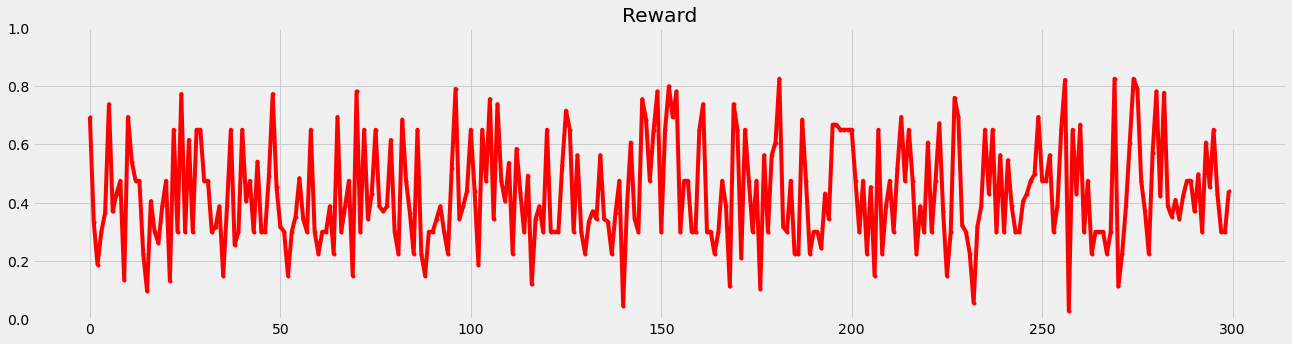

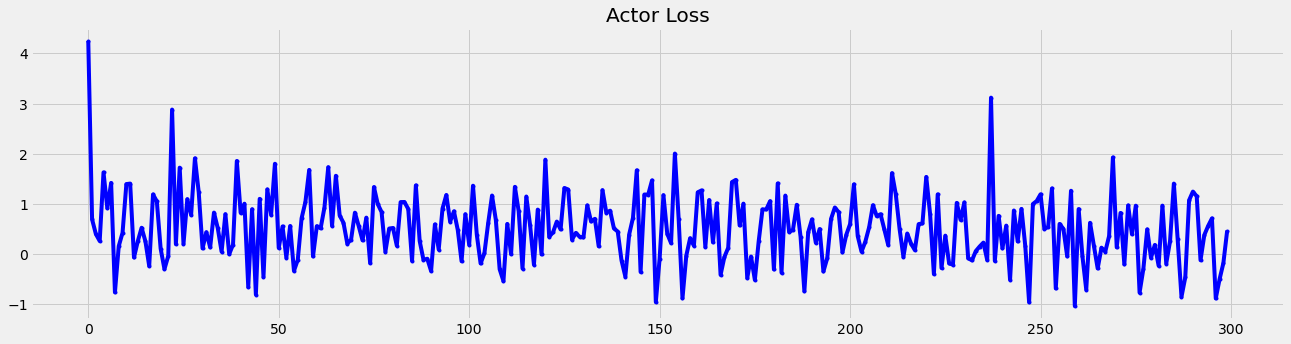

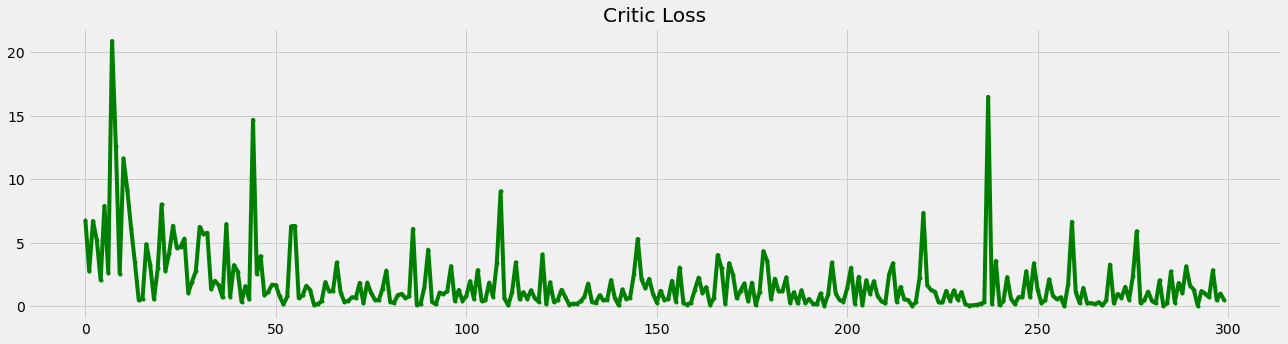

In [328]:
plt.figure(figsize=(20,5))
plt.title('Reward')
plt.plot(frac_l[::10], 'r.-')
plt.ylim(0,1)

plt.figure(figsize=(20,5))
plt.title('Actor Loss')
plt.plot(avg_actor_loss_l[::10], 'b.-')
plt.show()

plt.figure(figsize=(20,5))
plt.title('Critic Loss')
plt.plot(avg_critic_loss_l[::10], 'g.-')
plt.show()

In [8]:
num_episode = 3000
env = Bpp3DEnv()
agent = ActorCriticAgent(s_size=20*20, a_size=200*20, lr=1e-8, gamma=0.99, action_size=1)
frac_l, avg_actor_loss_l, avg_critic_loss_l = [], [], []
N_MDD = 17

for episode in range(num_episode):
    st = time.time()
    env.reset()
    done = False
    step = 0
    
    history_l, upleft_l, used_boxes = [], [], []
    a_ops_l, next_history_l, reward_l = [], [], []
    action_l = []
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1,
                                     N_mdd=N_MDD,is_prediv='2h')
    boxes = boxes[0]
    
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1
        
        #hist
        for i, ul in enumerate(upleft_l):
            w_upleft += whole_upleft(*box_cornel([ul[0], ul[1]], used_boxes[i][0],
                                                used_boxes[i][1]), box[0], box[1])
        f_upleft = feasible_location(history, w_upleft,
                                    box[0],box[1],box[2],
                                    state_H = env.height,is2d=False)
        
        a_ops = action_options(f_upleft)
        action_ops, action = agent.get_action(history/20, a_ops)
        
        if action != -1:
            upleft = f_upleft[action]
            next_history = env.step(upleft, box[0], box[1], box[2])
            upleft_l.append(upleft)
            history_l.append(history)
            used_boxes.append(box)
            a_ops_l.append(action_ops)
            next_history_l.append(next_history)
            reward_l.append(env.terminal_reward())
            action_l.append(action)
            
            if step == len(boxes):
                done = True
        else:
            done = True
            
        if done:
            frac_l.append(env.terminal_reward())
            
            agent.train(history_l, action_l, a_ops_l, next_history_l, reward_l)
            avg_actor_loss_l.append(np.squeeze(agent.avg_actor_loss / float(step)))
            avg_critic_loss_l.append(np.squeeze(agent.avg_critic_loss / float(step)))
    log = "====episode: {:5d} | ".format(episode)
    log += "Terminal Reward: {:.3f} | ".format(env.terminal_reward())
    log += "Actor Loss: {:6f} | ".format(agent.avg_actor_loss.numpy()[0][0] / float(step))
    log += "Critic Loss: {:6f} | ".format(agent.avg_critic_loss.numpy()[0][0] / float(step))
    log += "time: {:.3f}".format(time.time() - st)
    print(log)
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

====episode:     0 | Terminal Reward: 0.300 | Actor Loss: 1.776681 | Critic Loss: 1.492835 | time: 0.698
====episode:     1 | Terminal Reward: 0.562 | Actor Loss: 2.689887 | Critic Loss: 10.310244 | time: 0.149
====episode:     2 | Terminal Reward: 0.475 | Actor Loss: 1.021845 | Critic Loss: 2.235922 | time: 0.207
====episode:     3 | Terminal Reward: 0.300 | Actor Loss: -0.738440 | Critic Loss: 7.183370 | time: 0.152
====episode:     4 | Terminal Reward: 0.431 | Actor Loss: 3.098438 | Critic Loss: 5.440227 | time: 0.144
====episode:     5 | Terminal Reward: 0.300 | Actor Loss: 0.171540 | Critic Loss: 0.840986 | time: 0.123
====episode:     6 | Terminal Reward: 0.300 | Actor Loss: 0.982439 | Critic Loss: 4.941458 | time: 0.125
====episode:     7 | Terminal Reward: 0.650 | Actor Loss: 1.473730 | Critic Loss: 6.760169 | time: 0.226
====episode:     8 | Terminal Reward: 0.431 | Actor Loss: 0.747160 | Critic Loss: 9.561985 | time: 0.225
====episode:     9 | Terminal Reward: 0.738 | Actor L

====episode:    80 | Terminal Reward: 0.335 | Actor Loss: 1.834105 | Critic Loss: 9.526923 | time: 0.129
====episode:    81 | Terminal Reward: 0.650 | Actor Loss: 3.383211 | Critic Loss: 4.054984 | time: 0.199
====episode:    82 | Terminal Reward: 0.388 | Actor Loss: 0.496376 | Critic Loss: 1.037595 | time: 0.125
====episode:    83 | Terminal Reward: 0.571 | Actor Loss: -0.445020 | Critic Loss: 3.996143 | time: 0.252
====episode:    84 | Terminal Reward: 0.650 | Actor Loss: 2.929262 | Critic Loss: 6.549586 | time: 0.291
====episode:    85 | Terminal Reward: 0.720 | Actor Loss: 2.117046 | Critic Loss: 5.262679 | time: 0.260
====episode:    86 | Terminal Reward: 0.335 | Actor Loss: -0.487019 | Critic Loss: 3.322206 | time: 0.183
====episode:    87 | Terminal Reward: 0.650 | Actor Loss: 1.703429 | Critic Loss: 8.909351 | time: 0.141
====episode:    88 | Terminal Reward: 0.335 | Actor Loss: 0.526830 | Critic Loss: 2.004864 | time: 0.124
====episode:    89 | Terminal Reward: 0.300 | Actor L

====episode:   158 | Terminal Reward: 0.650 | Actor Loss: 1.002368 | Critic Loss: 4.876837 | time: 0.249
====episode:   159 | Terminal Reward: 0.300 | Actor Loss: 0.672192 | Critic Loss: 0.594492 | time: 0.152
====episode:   160 | Terminal Reward: 0.225 | Actor Loss: 0.979726 | Critic Loss: 0.549489 | time: 0.093
====episode:   161 | Terminal Reward: 0.458 | Actor Loss: 0.449889 | Critic Loss: 0.375153 | time: 0.171
====episode:   162 | Terminal Reward: 0.225 | Actor Loss: -0.083095 | Critic Loss: 6.619100 | time: 0.107
====episode:   163 | Terminal Reward: 0.300 | Actor Loss: -0.324210 | Critic Loss: 18.364543 | time: 0.211
====episode:   164 | Terminal Reward: 0.225 | Actor Loss: -0.377562 | Critic Loss: 2.129705 | time: 0.156
====episode:   165 | Terminal Reward: 0.545 | Actor Loss: 1.939256 | Critic Loss: 2.249220 | time: 0.121
====episode:   166 | Terminal Reward: 0.475 | Actor Loss: -0.550466 | Critic Loss: 25.893650 | time: 0.102
====episode:   167 | Terminal Reward: 0.113 | Act

====episode:   236 | Terminal Reward: 0.388 | Actor Loss: 2.038919 | Critic Loss: 1.099447 | time: 0.192
====episode:   237 | Terminal Reward: 0.352 | Actor Loss: 0.586059 | Critic Loss: 1.189351 | time: 0.172
====episode:   238 | Terminal Reward: 0.475 | Actor Loss: 0.823736 | Critic Loss: 9.354746 | time: 0.154
====episode:   239 | Terminal Reward: 0.738 | Actor Loss: 2.200207 | Critic Loss: 8.165084 | time: 0.186
====episode:   240 | Terminal Reward: 0.300 | Actor Loss: 0.955286 | Critic Loss: 0.510981 | time: 0.106
====episode:   241 | Terminal Reward: 0.206 | Actor Loss: -0.948501 | Critic Loss: 5.040975 | time: 0.109
====episode:   242 | Terminal Reward: 0.225 | Actor Loss: 0.411470 | Critic Loss: 0.763404 | time: 0.192
====episode:   243 | Terminal Reward: 0.300 | Actor Loss: -0.665675 | Critic Loss: 2.608758 | time: 0.226
====episode:   244 | Terminal Reward: 0.738 | Actor Loss: 3.207960 | Critic Loss: 6.644407 | time: 0.173
====episode:   245 | Terminal Reward: 0.225 | Actor L

====episode:   314 | Terminal Reward: 0.738 | Actor Loss: 4.100721 | Critic Loss: 5.675117 | time: 0.225
====episode:   315 | Terminal Reward: 0.453 | Actor Loss: 1.120856 | Critic Loss: 3.076427 | time: 0.158
====episode:   316 | Terminal Reward: 0.075 | Actor Loss: 0.510190 | Critic Loss: 0.405858 | time: 0.045
====episode:   317 | Terminal Reward: 0.440 | Actor Loss: 1.507699 | Critic Loss: 1.042005 | time: 0.174
====episode:   318 | Terminal Reward: 0.606 | Actor Loss: 1.900123 | Critic Loss: 6.326698 | time: 0.204
====episode:   319 | Terminal Reward: 0.475 | Actor Loss: -0.502050 | Critic Loss: 14.950828 | time: 0.197
====episode:   320 | Terminal Reward: 0.388 | Actor Loss: 1.180150 | Critic Loss: 0.639839 | time: 0.148
====episode:   321 | Terminal Reward: 0.300 | Actor Loss: 0.335699 | Critic Loss: 0.264605 | time: 0.166
====episode:   322 | Terminal Reward: 0.225 | Actor Loss: 0.491581 | Critic Loss: 3.582247 | time: 0.148
====episode:   323 | Terminal Reward: 0.738 | Actor L

====episode:   393 | Terminal Reward: 0.562 | Actor Loss: 3.271026 | Critic Loss: 6.585536 | time: 0.229
====episode:   394 | Terminal Reward: 0.300 | Actor Loss: 0.470249 | Critic Loss: 0.376382 | time: 0.118
====episode:   395 | Terminal Reward: 0.440 | Actor Loss: 0.844224 | Critic Loss: 3.386255 | time: 0.172
====episode:   396 | Terminal Reward: 0.300 | Actor Loss: 0.692792 | Critic Loss: 4.356928 | time: 0.112
====episode:   397 | Terminal Reward: 0.475 | Actor Loss: 4.294964 | Critic Loss: 7.039583 | time: 0.168
====episode:   398 | Terminal Reward: 0.318 | Actor Loss: 0.105844 | Critic Loss: 15.683436 | time: 0.093
====episode:   399 | Terminal Reward: 0.672 | Actor Loss: 2.011460 | Critic Loss: 5.286148 | time: 0.137
====episode:   400 | Terminal Reward: 0.068 | Actor Loss: 0.141295 | Critic Loss: 0.057918 | time: 0.047
====episode:   401 | Terminal Reward: 0.562 | Actor Loss: 1.507324 | Critic Loss: 0.950966 | time: 0.200
====episode:   402 | Terminal Reward: 0.458 | Actor Lo

====episode:   471 | Terminal Reward: 0.650 | Actor Loss: -1.171563 | Critic Loss: 16.029241 | time: 0.189
====episode:   472 | Terminal Reward: 0.388 | Actor Loss: -0.515139 | Critic Loss: 4.014119 | time: 0.091
====episode:   473 | Terminal Reward: 0.300 | Actor Loss: 0.142219 | Critic Loss: 2.532045 | time: 0.182
====episode:   474 | Terminal Reward: 0.825 | Actor Loss: 1.081408 | Critic Loss: 5.947144 | time: 0.149
====episode:   475 | Terminal Reward: 0.650 | Actor Loss: 0.258151 | Critic Loss: 16.333153 | time: 0.203
====episode:   476 | Terminal Reward: 0.335 | Actor Loss: 0.653311 | Critic Loss: 1.469202 | time: 0.125
====episode:   477 | Terminal Reward: 0.650 | Actor Loss: 1.040398 | Critic Loss: 6.828570 | time: 0.220
====episode:   478 | Terminal Reward: 0.233 | Actor Loss: 0.308697 | Critic Loss: 0.096397 | time: 0.114
====episode:   479 | Terminal Reward: 0.541 | Actor Loss: 2.076212 | Critic Loss: 3.296248 | time: 0.216
====episode:   480 | Terminal Reward: 0.225 | Actor

====episode:   549 | Terminal Reward: 0.650 | Actor Loss: 1.620270 | Critic Loss: 2.375317 | time: 0.219
====episode:   550 | Terminal Reward: 0.188 | Actor Loss: 0.160201 | Critic Loss: 0.611434 | time: 0.079
====episode:   551 | Terminal Reward: 0.300 | Actor Loss: 1.296573 | Critic Loss: 0.862474 | time: 0.120
====episode:   552 | Terminal Reward: 0.300 | Actor Loss: 0.452226 | Critic Loss: 10.454749 | time: 0.093
====episode:   553 | Terminal Reward: 0.225 | Actor Loss: 0.825265 | Critic Loss: 0.414908 | time: 0.090
====episode:   554 | Terminal Reward: 0.225 | Actor Loss: 0.220577 | Critic Loss: 0.071923 | time: 0.123
====episode:   555 | Terminal Reward: 0.475 | Actor Loss: 0.130926 | Critic Loss: 0.206092 | time: 0.137
====episode:   556 | Terminal Reward: 0.453 | Actor Loss: 1.300698 | Critic Loss: 9.393990 | time: 0.169
====episode:   557 | Terminal Reward: 0.519 | Actor Loss: 1.760249 | Critic Loss: 1.198440 | time: 0.137
====episode:   558 | Terminal Reward: 0.300 | Actor Lo

====episode:   627 | Terminal Reward: 0.188 | Actor Loss: -0.013604 | Critic Loss: 0.188908 | time: 0.113
====episode:   628 | Terminal Reward: 0.300 | Actor Loss: 1.995597 | Critic Loss: 2.790786 | time: 0.149
====episode:   629 | Terminal Reward: 0.667 | Actor Loss: 2.442947 | Critic Loss: 4.721563 | time: 0.126
====episode:   630 | Terminal Reward: 0.225 | Actor Loss: 0.227842 | Critic Loss: 1.175351 | time: 0.146
====episode:   631 | Terminal Reward: 0.225 | Actor Loss: 0.802535 | Critic Loss: 0.400013 | time: 0.099
====episode:   632 | Terminal Reward: 0.694 | Actor Loss: -0.930665 | Critic Loss: 6.332369 | time: 0.193
====episode:   633 | Terminal Reward: 0.541 | Actor Loss: -1.490979 | Critic Loss: 1.991374 | time: 0.199
====episode:   634 | Terminal Reward: 0.206 | Actor Loss: -0.080824 | Critic Loss: 1.058984 | time: 0.148
====episode:   635 | Terminal Reward: 0.716 | Actor Loss: 3.388206 | Critic Loss: 5.593482 | time: 0.149
====episode:   636 | Terminal Reward: 0.225 | Actor

====episode:   706 | Terminal Reward: 0.650 | Actor Loss: 1.575642 | Critic Loss: 4.004897 | time: 0.173
====episode:   707 | Terminal Reward: 0.217 | Actor Loss: -0.516849 | Critic Loss: 0.514175 | time: 0.164
====episode:   708 | Terminal Reward: 0.388 | Actor Loss: 0.531194 | Critic Loss: 2.809252 | time: 0.116
====episode:   709 | Terminal Reward: 0.300 | Actor Loss: -0.543056 | Critic Loss: 11.624583 | time: 0.061
====episode:   710 | Terminal Reward: 0.615 | Actor Loss: 3.027831 | Critic Loss: 5.056001 | time: 0.153
====episode:   711 | Terminal Reward: 0.475 | Actor Loss: 0.789387 | Critic Loss: 1.565561 | time: 0.203
====episode:   712 | Terminal Reward: 0.650 | Actor Loss: 0.879676 | Critic Loss: 1.584634 | time: 0.258
====episode:   713 | Terminal Reward: 0.431 | Actor Loss: 1.141099 | Critic Loss: 3.424442 | time: 0.150
====episode:   714 | Terminal Reward: 0.694 | Actor Loss: 1.754467 | Critic Loss: 1.567710 | time: 0.189
====episode:   715 | Terminal Reward: 0.475 | Actor 

====episode:   784 | Terminal Reward: 0.388 | Actor Loss: 0.553073 | Critic Loss: 2.401272 | time: 0.111
====episode:   785 | Terminal Reward: 0.738 | Actor Loss: 3.401938 | Critic Loss: 4.265896 | time: 0.206
====episode:   786 | Terminal Reward: 0.825 | Actor Loss: 3.277241 | Critic Loss: 5.112015 | time: 0.191
====episode:   787 | Terminal Reward: 0.335 | Actor Loss: 1.984611 | Critic Loss: 3.355701 | time: 0.164
====episode:   788 | Terminal Reward: 0.458 | Actor Loss: 1.656564 | Critic Loss: 1.261428 | time: 0.156
====episode:   789 | Terminal Reward: 0.440 | Actor Loss: 2.135773 | Critic Loss: 3.247931 | time: 0.135
====episode:   790 | Terminal Reward: 0.562 | Actor Loss: 1.310175 | Critic Loss: 1.399069 | time: 0.223
====episode:   791 | Terminal Reward: 0.388 | Actor Loss: 1.460309 | Critic Loss: 2.613045 | time: 0.174
====episode:   792 | Terminal Reward: 0.158 | Actor Loss: -0.328080 | Critic Loss: 0.232732 | time: 0.129
====episode:   793 | Terminal Reward: 0.475 | Actor Lo

====episode:   862 | Terminal Reward: 0.388 | Actor Loss: 1.185045 | Critic Loss: 0.940202 | time: 0.170
====episode:   863 | Terminal Reward: 0.094 | Actor Loss: -0.668217 | Critic Loss: 1.246075 | time: 0.052
====episode:   864 | Terminal Reward: 0.527 | Actor Loss: 1.034304 | Critic Loss: 3.475443 | time: 0.132
====episode:   865 | Terminal Reward: 0.388 | Actor Loss: 0.741267 | Critic Loss: 0.876752 | time: 0.122
====episode:   866 | Terminal Reward: 0.440 | Actor Loss: 0.524059 | Critic Loss: 1.582142 | time: 0.164
====episode:   867 | Terminal Reward: 0.188 | Actor Loss: -0.557088 | Critic Loss: 3.499904 | time: 0.093
====episode:   868 | Terminal Reward: 0.650 | Actor Loss: 2.199008 | Critic Loss: 1.623761 | time: 0.249
====episode:   869 | Terminal Reward: 0.225 | Actor Loss: 0.554831 | Critic Loss: 0.207866 | time: 0.091
====episode:   870 | Terminal Reward: 0.694 | Actor Loss: -2.312593 | Critic Loss: 6.904148 | time: 0.223
====episode:   871 | Terminal Reward: 0.075 | Actor 

====episode:   940 | Terminal Reward: 0.300 | Actor Loss: 0.545072 | Critic Loss: 0.608738 | time: 0.139
====episode:   941 | Terminal Reward: 0.300 | Actor Loss: 0.192889 | Critic Loss: 0.315088 | time: 0.143
====episode:   942 | Terminal Reward: 0.694 | Actor Loss: 3.005955 | Critic Loss: 4.530638 | time: 0.180
====episode:   943 | Terminal Reward: 0.300 | Actor Loss: 0.477145 | Critic Loss: 0.240702 | time: 0.118
====episode:   944 | Terminal Reward: 0.300 | Actor Loss: 0.103927 | Critic Loss: 0.099738 | time: 0.137
====episode:   945 | Terminal Reward: 0.650 | Actor Loss: 0.561263 | Critic Loss: 0.635237 | time: 0.230
====episode:   946 | Terminal Reward: 0.335 | Actor Loss: 0.240731 | Critic Loss: 0.838282 | time: 0.110
====episode:   947 | Terminal Reward: 0.388 | Actor Loss: 1.337830 | Critic Loss: 1.845099 | time: 0.202
====episode:   948 | Terminal Reward: 0.300 | Actor Loss: 0.862957 | Critic Loss: 0.770848 | time: 0.172
====episode:   949 | Terminal Reward: 0.388 | Actor Los

====episode:  1018 | Terminal Reward: 0.475 | Actor Loss: 1.703929 | Critic Loss: 1.624817 | time: 0.122
====episode:  1019 | Terminal Reward: 0.527 | Actor Loss: 2.868595 | Critic Loss: 4.641852 | time: 0.246
====episode:  1020 | Terminal Reward: 0.886 | Actor Loss: -0.117922 | Critic Loss: 0.445316 | time: 0.259
====episode:  1021 | Terminal Reward: 0.475 | Actor Loss: 1.088914 | Critic Loss: 0.639682 | time: 0.183
====episode:  1022 | Terminal Reward: 0.405 | Actor Loss: -0.137020 | Critic Loss: 1.584421 | time: 0.200
====episode:  1023 | Terminal Reward: 0.475 | Actor Loss: 0.842617 | Critic Loss: 0.673940 | time: 0.160
====episode:  1024 | Terminal Reward: 0.615 | Actor Loss: 1.856668 | Critic Loss: 3.116472 | time: 0.174
====episode:  1025 | Terminal Reward: 0.188 | Actor Loss: -0.605777 | Critic Loss: 4.493361 | time: 0.219
====episode:  1026 | Terminal Reward: 0.300 | Actor Loss: 1.153855 | Critic Loss: 0.485578 | time: 0.144
====episode:  1027 | Terminal Reward: 0.150 | Actor 

====episode:  1096 | Terminal Reward: 0.738 | Actor Loss: 0.715133 | Critic Loss: 1.285943 | time: 0.254
====episode:  1097 | Terminal Reward: 0.300 | Actor Loss: 0.686054 | Critic Loss: 0.398678 | time: 0.191
====episode:  1098 | Terminal Reward: 0.300 | Actor Loss: 2.699080 | Critic Loss: 7.016746 | time: 0.149
====episode:  1099 | Terminal Reward: 0.541 | Actor Loss: 0.841557 | Critic Loss: 0.707017 | time: 0.201
====episode:  1100 | Terminal Reward: 0.335 | Actor Loss: 1.173478 | Critic Loss: 1.100145 | time: 0.193
====episode:  1101 | Terminal Reward: 0.300 | Actor Loss: 0.687001 | Critic Loss: 0.775144 | time: 0.225
====episode:  1102 | Terminal Reward: 0.440 | Actor Loss: 0.831508 | Critic Loss: 0.940745 | time: 0.193
====episode:  1103 | Terminal Reward: 0.650 | Actor Loss: 3.717264 | Critic Loss: 13.514657 | time: 0.289
====episode:  1104 | Terminal Reward: 0.519 | Actor Loss: 1.985763 | Critic Loss: 2.294675 | time: 0.261
====episode:  1105 | Terminal Reward: 0.431 | Actor Lo

====episode:  1174 | Terminal Reward: 0.672 | Actor Loss: 0.862876 | Critic Loss: 0.659264 | time: 0.173
====episode:  1175 | Terminal Reward: 0.475 | Actor Loss: 0.586562 | Critic Loss: 0.922031 | time: 0.150
====episode:  1176 | Terminal Reward: 0.366 | Actor Loss: 2.163353 | Critic Loss: 3.598629 | time: 0.175
====episode:  1177 | Terminal Reward: 0.584 | Actor Loss: 1.313446 | Critic Loss: 1.046559 | time: 0.217
====episode:  1178 | Terminal Reward: 0.422 | Actor Loss: 1.690871 | Critic Loss: 3.137809 | time: 0.172
====episode:  1179 | Terminal Reward: 0.352 | Actor Loss: 2.190656 | Critic Loss: 3.985111 | time: 0.168
====episode:  1180 | Terminal Reward: 0.475 | Actor Loss: 1.638914 | Critic Loss: 1.236805 | time: 0.151
====episode:  1181 | Terminal Reward: 0.135 | Actor Loss: 0.346378 | Critic Loss: 0.329101 | time: 0.085
====episode:  1182 | Terminal Reward: 0.352 | Actor Loss: 0.762172 | Critic Loss: 0.980928 | time: 0.150
====episode:  1183 | Terminal Reward: 0.206 | Actor Los

====episode:  1252 | Terminal Reward: 0.895 | Actor Loss: 0.494386 | Critic Loss: 2.443315 | time: 0.256
====episode:  1253 | Terminal Reward: 0.300 | Actor Loss: 0.713395 | Critic Loss: 0.540928 | time: 0.217
====episode:  1254 | Terminal Reward: 0.225 | Actor Loss: -0.037000 | Critic Loss: 0.994836 | time: 0.172
====episode:  1255 | Terminal Reward: 0.703 | Actor Loss: 1.013308 | Critic Loss: 1.116029 | time: 0.226
====episode:  1256 | Terminal Reward: 0.562 | Actor Loss: 0.796249 | Critic Loss: 1.279723 | time: 0.229
====episode:  1257 | Terminal Reward: 0.225 | Actor Loss: 0.625141 | Critic Loss: 0.325429 | time: 0.106
====episode:  1258 | Terminal Reward: 0.388 | Actor Loss: -2.240797 | Critic Loss: 15.250411 | time: 0.186
====episode:  1259 | Terminal Reward: 0.650 | Actor Loss: 1.756994 | Critic Loss: 1.779288 | time: 0.260
====episode:  1260 | Terminal Reward: 0.475 | Actor Loss: 1.449772 | Critic Loss: 0.821135 | time: 0.197
====episode:  1261 | Terminal Reward: 0.300 | Actor 

====episode:  1331 | Terminal Reward: 0.318 | Actor Loss: -0.050365 | Critic Loss: 0.740264 | time: 0.138
====episode:  1332 | Terminal Reward: 0.225 | Actor Loss: -0.052232 | Critic Loss: 1.456335 | time: 0.130
====episode:  1333 | Terminal Reward: 0.431 | Actor Loss: 0.106299 | Critic Loss: 1.318089 | time: 0.183
====episode:  1334 | Terminal Reward: 0.169 | Actor Loss: 0.110720 | Critic Loss: 0.677124 | time: 0.080
====episode:  1335 | Terminal Reward: 0.650 | Actor Loss: 2.237314 | Critic Loss: 3.486891 | time: 0.118
====episode:  1336 | Terminal Reward: 0.475 | Actor Loss: 2.084470 | Critic Loss: 2.282886 | time: 0.193
====episode:  1337 | Terminal Reward: 0.615 | Actor Loss: 1.186408 | Critic Loss: 0.715383 | time: 0.238
====episode:  1338 | Terminal Reward: 0.388 | Actor Loss: 1.322953 | Critic Loss: 0.773840 | time: 0.160
====episode:  1339 | Terminal Reward: 0.300 | Actor Loss: 0.246206 | Critic Loss: 0.147790 | time: 0.137
====episode:  1340 | Terminal Reward: 0.475 | Actor L

====episode:  1409 | Terminal Reward: 0.188 | Actor Loss: 0.441278 | Critic Loss: 1.041866 | time: 0.198
====episode:  1410 | Terminal Reward: 0.458 | Actor Loss: 1.158837 | Critic Loss: 0.578758 | time: 0.172
====episode:  1411 | Terminal Reward: 0.650 | Actor Loss: 2.605798 | Critic Loss: 3.734167 | time: 0.149
====episode:  1412 | Terminal Reward: 0.738 | Actor Loss: 2.276595 | Critic Loss: 1.656690 | time: 0.252
====episode:  1413 | Terminal Reward: 0.197 | Actor Loss: 0.712325 | Critic Loss: 0.532684 | time: 0.120
====episode:  1414 | Terminal Reward: 0.150 | Actor Loss: -0.013094 | Critic Loss: 0.059577 | time: 0.121
====episode:  1415 | Terminal Reward: 0.562 | Actor Loss: 0.778433 | Critic Loss: 1.199446 | time: 0.133
====episode:  1416 | Terminal Reward: 0.240 | Actor Loss: 0.394459 | Critic Loss: 0.786651 | time: 0.084
====episode:  1417 | Terminal Reward: 0.335 | Actor Loss: 1.800029 | Critic Loss: 2.193022 | time: 0.183
====episode:  1418 | Terminal Reward: 0.436 | Actor Lo

====episode:  1487 | Terminal Reward: 0.300 | Actor Loss: -0.186719 | Critic Loss: 2.413853 | time: 0.206
====episode:  1488 | Terminal Reward: 0.225 | Actor Loss: 0.412973 | Critic Loss: 0.223489 | time: 0.117
====episode:  1489 | Terminal Reward: 0.672 | Actor Loss: 1.696356 | Critic Loss: 3.144954 | time: 0.118
====episode:  1490 | Terminal Reward: 0.431 | Actor Loss: 1.170847 | Critic Loss: 4.271091 | time: 0.131
====episode:  1491 | Terminal Reward: 0.650 | Actor Loss: 1.360999 | Critic Loss: 1.686997 | time: 0.225
====episode:  1492 | Terminal Reward: 0.352 | Actor Loss: 0.695240 | Critic Loss: 0.349611 | time: 0.178
====episode:  1493 | Terminal Reward: 0.388 | Actor Loss: 0.211439 | Critic Loss: 1.056428 | time: 0.152
====episode:  1494 | Terminal Reward: 0.203 | Actor Loss: 0.091788 | Critic Loss: 1.404875 | time: 0.103
====episode:  1495 | Terminal Reward: 0.405 | Actor Loss: -0.468111 | Critic Loss: 1.781231 | time: 0.136
====episode:  1496 | Terminal Reward: 0.300 | Actor L

====episode:  1565 | Terminal Reward: 0.650 | Actor Loss: -0.847032 | Critic Loss: 0.650174 | time: 0.225
====episode:  1566 | Terminal Reward: 0.519 | Actor Loss: 1.635340 | Critic Loss: 1.998182 | time: 0.239
====episode:  1567 | Terminal Reward: 0.475 | Actor Loss: -0.990951 | Critic Loss: 2.803248 | time: 0.211
====episode:  1568 | Terminal Reward: 0.388 | Actor Loss: 1.138896 | Critic Loss: 2.361547 | time: 0.155
====episode:  1569 | Terminal Reward: 0.475 | Actor Loss: 1.764401 | Critic Loss: 3.437842 | time: 0.188
====episode:  1570 | Terminal Reward: 0.431 | Actor Loss: 1.634510 | Critic Loss: 2.078693 | time: 0.139
====episode:  1571 | Terminal Reward: 0.344 | Actor Loss: 1.201157 | Critic Loss: 1.724768 | time: 0.149
====episode:  1572 | Terminal Reward: 0.300 | Actor Loss: 0.682474 | Critic Loss: 1.289656 | time: 0.190
====episode:  1573 | Terminal Reward: 0.206 | Actor Loss: 0.104534 | Critic Loss: 0.171313 | time: 0.066
====episode:  1574 | Terminal Reward: 0.300 | Actor L

====episode:  1644 | Terminal Reward: 0.440 | Actor Loss: 1.676163 | Critic Loss: 2.850625 | time: 0.150
====episode:  1645 | Terminal Reward: 0.300 | Actor Loss: 0.141957 | Critic Loss: 3.734846 | time: 0.168
====episode:  1646 | Terminal Reward: 0.300 | Actor Loss: -0.623556 | Critic Loss: 0.490451 | time: 0.170
====episode:  1647 | Terminal Reward: 0.650 | Actor Loss: 0.266762 | Critic Loss: 0.342143 | time: 0.261
====episode:  1648 | Terminal Reward: 0.475 | Actor Loss: 2.268312 | Critic Loss: 4.448792 | time: 0.147
====episode:  1649 | Terminal Reward: 0.694 | Actor Loss: 0.119942 | Critic Loss: 0.555749 | time: 0.291
====episode:  1650 | Terminal Reward: 0.790 | Actor Loss: 2.017547 | Critic Loss: 2.099007 | time: 0.163
====episode:  1651 | Terminal Reward: 0.300 | Actor Loss: 1.047443 | Critic Loss: 0.580652 | time: 0.167
====episode:  1652 | Terminal Reward: 0.318 | Actor Loss: 0.050140 | Critic Loss: 0.152821 | time: 0.135
====episode:  1653 | Terminal Reward: 0.545 | Actor Lo

====episode:  1722 | Terminal Reward: 0.475 | Actor Loss: -0.432803 | Critic Loss: 0.277660 | time: 0.222
====episode:  1723 | Terminal Reward: 0.562 | Actor Loss: -0.248828 | Critic Loss: 3.954954 | time: 0.185
====episode:  1724 | Terminal Reward: 0.388 | Actor Loss: -0.177888 | Critic Loss: 0.646305 | time: 0.159
====episode:  1725 | Terminal Reward: 0.370 | Actor Loss: 3.241970 | Critic Loss: 6.043003 | time: 0.183
====episode:  1726 | Terminal Reward: 0.388 | Actor Loss: 0.176117 | Critic Loss: 2.420307 | time: 0.167
====episode:  1727 | Terminal Reward: 0.188 | Actor Loss: 0.734776 | Critic Loss: 1.190439 | time: 0.104
====episode:  1728 | Terminal Reward: 0.755 | Actor Loss: 0.490468 | Critic Loss: 1.435616 | time: 0.272
====episode:  1729 | Terminal Reward: 0.300 | Actor Loss: 0.515468 | Critic Loss: 0.396230 | time: 0.131
====episode:  1730 | Terminal Reward: 0.388 | Actor Loss: 0.126695 | Critic Loss: 0.135773 | time: 0.137
====episode:  1731 | Terminal Reward: 0.475 | Actor 

====episode:  1800 | Terminal Reward: 0.300 | Actor Loss: 1.460310 | Critic Loss: 1.361126 | time: 0.171
====episode:  1801 | Terminal Reward: 0.405 | Actor Loss: -1.006686 | Critic Loss: 7.498756 | time: 0.158
====episode:  1802 | Terminal Reward: 0.300 | Actor Loss: 1.270140 | Critic Loss: 1.095059 | time: 0.154
====episode:  1803 | Terminal Reward: 0.225 | Actor Loss: -0.192536 | Critic Loss: 0.929606 | time: 0.059
====episode:  1804 | Terminal Reward: 0.225 | Actor Loss: 0.493852 | Critic Loss: 0.461680 | time: 0.120
====episode:  1805 | Terminal Reward: 0.352 | Actor Loss: 3.135772 | Critic Loss: 11.617860 | time: 0.184
====episode:  1806 | Terminal Reward: 0.300 | Actor Loss: -0.590067 | Critic Loss: 1.889000 | time: 0.100
====episode:  1807 | Terminal Reward: 0.738 | Actor Loss: 0.261338 | Critic Loss: 0.273652 | time: 0.255
====episode:  1808 | Terminal Reward: 0.225 | Actor Loss: 0.489530 | Critic Loss: 0.191880 | time: 0.099
====episode:  1809 | Terminal Reward: 0.225 | Actor

====episode:  1879 | Terminal Reward: 0.650 | Actor Loss: 2.583480 | Critic Loss: 5.059133 | time: 0.207
====episode:  1880 | Terminal Reward: 0.405 | Actor Loss: 1.509606 | Critic Loss: 1.505230 | time: 0.168
====episode:  1881 | Terminal Reward: 0.650 | Actor Loss: 0.573835 | Critic Loss: 1.034300 | time: 0.252
====episode:  1882 | Terminal Reward: 0.650 | Actor Loss: 0.861867 | Critic Loss: 1.268480 | time: 0.254
====episode:  1883 | Terminal Reward: 0.045 | Actor Loss: 0.106309 | Critic Loss: 0.038294 | time: 0.067
====episode:  1884 | Terminal Reward: 0.388 | Actor Loss: 0.460133 | Critic Loss: 0.712606 | time: 0.134
====episode:  1885 | Terminal Reward: 0.131 | Actor Loss: 0.310831 | Critic Loss: 0.220878 | time: 0.082
====episode:  1886 | Terminal Reward: 0.650 | Actor Loss: 0.955171 | Critic Loss: 3.533423 | time: 0.133
====episode:  1887 | Terminal Reward: 0.431 | Actor Loss: 2.485202 | Critic Loss: 4.294289 | time: 0.117
====episode:  1888 | Terminal Reward: 0.405 | Actor Los

====episode:  1958 | Terminal Reward: 0.650 | Actor Loss: 0.534409 | Critic Loss: 2.857140 | time: 0.190
====episode:  1959 | Terminal Reward: 0.492 | Actor Loss: 1.547547 | Critic Loss: 1.581013 | time: 0.167
====episode:  1960 | Terminal Reward: 0.236 | Actor Loss: 0.687529 | Critic Loss: 1.915849 | time: 0.165
====episode:  1961 | Terminal Reward: 0.606 | Actor Loss: -0.030943 | Critic Loss: 0.189709 | time: 0.268
====episode:  1962 | Terminal Reward: 0.388 | Actor Loss: 1.212340 | Critic Loss: 2.541115 | time: 0.177
====episode:  1963 | Terminal Reward: 0.388 | Actor Loss: 0.655298 | Critic Loss: 1.591367 | time: 0.156
====episode:  1964 | Terminal Reward: 0.475 | Actor Loss: 1.925187 | Critic Loss: 3.650477 | time: 0.199
====episode:  1965 | Terminal Reward: 0.527 | Actor Loss: 1.641337 | Critic Loss: 6.929749 | time: 0.248
====episode:  1966 | Terminal Reward: 0.562 | Actor Loss: 1.734775 | Critic Loss: 1.325216 | time: 0.178
====episode:  1967 | Terminal Reward: 0.300 | Actor Lo

====episode:  2036 | Terminal Reward: 0.475 | Actor Loss: 2.693617 | Critic Loss: 4.598406 | time: 0.222
====episode:  2037 | Terminal Reward: 0.825 | Actor Loss: -0.129691 | Critic Loss: 1.336005 | time: 0.270
====episode:  2038 | Terminal Reward: 0.366 | Actor Loss: 0.506220 | Critic Loss: 1.293457 | time: 0.163
====episode:  2039 | Terminal Reward: 0.300 | Actor Loss: 1.042591 | Critic Loss: 0.854256 | time: 0.123
====episode:  2040 | Terminal Reward: 0.685 | Actor Loss: 1.207252 | Critic Loss: 1.193023 | time: 0.237
====episode:  2041 | Terminal Reward: 0.431 | Actor Loss: 1.185016 | Critic Loss: 1.094039 | time: 0.119
====episode:  2042 | Terminal Reward: 0.738 | Actor Loss: 0.262190 | Critic Loss: 2.239609 | time: 0.164
====episode:  2043 | Terminal Reward: 0.440 | Actor Loss: 0.858656 | Critic Loss: 0.720916 | time: 0.132
====episode:  2044 | Terminal Reward: 0.300 | Actor Loss: 0.596118 | Critic Loss: 0.698261 | time: 0.101
====episode:  2045 | Terminal Reward: 0.685 | Actor Lo

====episode:  2114 | Terminal Reward: 0.210 | Actor Loss: 0.113295 | Critic Loss: 0.163879 | time: 0.150
====episode:  2115 | Terminal Reward: 0.300 | Actor Loss: 0.610802 | Critic Loss: 0.393781 | time: 0.226
====episode:  2116 | Terminal Reward: 0.825 | Actor Loss: -0.628410 | Critic Loss: 9.681058 | time: 0.266
====episode:  2117 | Terminal Reward: 0.300 | Actor Loss: -0.253185 | Critic Loss: 0.383553 | time: 0.155
====episode:  2118 | Terminal Reward: 0.475 | Actor Loss: -0.002143 | Critic Loss: 0.753951 | time: 0.220
====episode:  2119 | Terminal Reward: 0.475 | Actor Loss: -0.648101 | Critic Loss: 1.479063 | time: 0.136
====episode:  2120 | Terminal Reward: 0.650 | Actor Loss: 0.768292 | Critic Loss: 0.526192 | time: 0.253
====episode:  2121 | Terminal Reward: 0.300 | Actor Loss: 0.471988 | Critic Loss: 0.186437 | time: 0.155
====episode:  2122 | Terminal Reward: 0.344 | Actor Loss: 0.010215 | Critic Loss: 0.393026 | time: 0.122
====episode:  2123 | Terminal Reward: 0.300 | Actor

====episode:  2193 | Terminal Reward: 0.300 | Actor Loss: 0.626991 | Critic Loss: 1.035752 | time: 0.118
====episode:  2194 | Terminal Reward: 0.388 | Actor Loss: 1.693787 | Critic Loss: 6.810099 | time: 0.233
====episode:  2195 | Terminal Reward: 0.225 | Actor Loss: -0.859673 | Critic Loss: 4.739730 | time: 0.104
====episode:  2196 | Terminal Reward: 0.300 | Actor Loss: 1.391368 | Critic Loss: 1.213241 | time: 0.203
====episode:  2197 | Terminal Reward: 0.475 | Actor Loss: 1.836023 | Critic Loss: 2.873482 | time: 0.182
====episode:  2198 | Terminal Reward: 0.422 | Actor Loss: 1.106755 | Critic Loss: 1.029187 | time: 0.116
====episode:  2199 | Terminal Reward: 0.440 | Actor Loss: 1.199541 | Critic Loss: 0.991491 | time: 0.147
====episode:  2200 | Terminal Reward: 0.300 | Actor Loss: -0.283855 | Critic Loss: 0.362595 | time: 0.117
====episode:  2201 | Terminal Reward: 0.650 | Actor Loss: 1.212209 | Critic Loss: 1.118817 | time: 0.117
====episode:  2202 | Terminal Reward: 0.650 | Actor L

====episode:  2271 | Terminal Reward: 0.685 | Actor Loss: 0.235407 | Critic Loss: 1.773306 | time: 0.221
====episode:  2272 | Terminal Reward: 0.475 | Actor Loss: 0.312884 | Critic Loss: 1.253047 | time: 0.160
====episode:  2273 | Terminal Reward: 0.150 | Actor Loss: 0.305018 | Critic Loss: 0.564151 | time: 0.117
====episode:  2274 | Terminal Reward: 0.300 | Actor Loss: -0.172283 | Critic Loss: 2.629559 | time: 0.210
====episode:  2275 | Terminal Reward: 0.263 | Actor Loss: 2.042078 | Critic Loss: 3.222750 | time: 0.194
====episode:  2276 | Terminal Reward: 0.405 | Actor Loss: 0.511351 | Critic Loss: 0.393643 | time: 0.160
====episode:  2277 | Terminal Reward: 0.225 | Actor Loss: 0.625202 | Critic Loss: 0.586478 | time: 0.118
====episode:  2278 | Terminal Reward: 0.440 | Actor Loss: 1.717893 | Critic Loss: 2.891047 | time: 0.232
====episode:  2279 | Terminal Reward: 0.475 | Actor Loss: 1.470479 | Critic Loss: 2.571141 | time: 0.134
====episode:  2280 | Terminal Reward: 0.188 | Actor Lo

====episode:  2350 | Terminal Reward: 0.562 | Actor Loss: 1.691198 | Critic Loss: 1.468179 | time: 0.201
====episode:  2351 | Terminal Reward: 0.475 | Actor Loss: 1.364085 | Critic Loss: 2.207763 | time: 0.116
====episode:  2352 | Terminal Reward: 0.886 | Actor Loss: 0.066290 | Critic Loss: 0.633415 | time: 0.235
====episode:  2353 | Terminal Reward: 0.344 | Actor Loss: -0.855683 | Critic Loss: 5.178171 | time: 0.181
====episode:  2354 | Terminal Reward: 0.519 | Actor Loss: 2.242664 | Critic Loss: 2.559825 | time: 0.215
====episode:  2355 | Terminal Reward: 0.606 | Actor Loss: -1.694630 | Critic Loss: 16.325963 | time: 0.233
====episode:  2356 | Terminal Reward: 0.716 | Actor Loss: 2.340727 | Critic Loss: 7.332770 | time: 0.252
====episode:  2357 | Terminal Reward: 0.475 | Actor Loss: -0.900595 | Critic Loss: 3.056659 | time: 0.241
====episode:  2358 | Terminal Reward: 0.344 | Actor Loss: 1.181129 | Critic Loss: 1.491495 | time: 0.140
====episode:  2359 | Terminal Reward: 0.519 | Actor

====episode:  2429 | Terminal Reward: 0.300 | Actor Loss: 0.123407 | Critic Loss: 0.152799 | time: 0.116
====episode:  2430 | Terminal Reward: 0.755 | Actor Loss: 0.649367 | Critic Loss: 1.111150 | time: 0.232
====episode:  2431 | Terminal Reward: 0.475 | Actor Loss: 2.636135 | Critic Loss: 8.849729 | time: 0.148
====episode:  2432 | Terminal Reward: 0.300 | Actor Loss: -0.864729 | Critic Loss: 0.405188 | time: 0.227
====episode:  2433 | Terminal Reward: 0.790 | Actor Loss: 1.821034 | Critic Loss: 3.744972 | time: 0.184
====episode:  2434 | Terminal Reward: 0.694 | Actor Loss: 1.524632 | Critic Loss: 2.473439 | time: 0.194
====episode:  2435 | Terminal Reward: 0.650 | Actor Loss: 1.788018 | Critic Loss: 2.150535 | time: 0.201
====episode:  2436 | Terminal Reward: 0.388 | Actor Loss: 1.165924 | Critic Loss: 4.073754 | time: 0.173
====episode:  2437 | Terminal Reward: 0.475 | Actor Loss: 0.718525 | Critic Loss: 0.662691 | time: 0.100
====episode:  2438 | Terminal Reward: 0.225 | Actor Lo

====episode:  2507 | Terminal Reward: 0.650 | Actor Loss: 1.861189 | Critic Loss: 5.048997 | time: 0.186
====episode:  2508 | Terminal Reward: 0.150 | Actor Loss: 0.982482 | Critic Loss: 0.834297 | time: 0.082
====episode:  2509 | Terminal Reward: 0.300 | Actor Loss: -0.028666 | Critic Loss: 2.881585 | time: 0.132
====episode:  2510 | Terminal Reward: 0.650 | Actor Loss: 1.154757 | Critic Loss: 1.404242 | time: 0.190
====episode:  2511 | Terminal Reward: 0.405 | Actor Loss: 2.176263 | Critic Loss: 3.557528 | time: 0.187
====episode:  2512 | Terminal Reward: 0.431 | Actor Loss: -0.880041 | Critic Loss: 3.983309 | time: 0.141
====episode:  2513 | Terminal Reward: 0.475 | Actor Loss: 0.327870 | Critic Loss: 0.411577 | time: 0.165
====episode:  2514 | Terminal Reward: 0.300 | Actor Loss: 0.428721 | Critic Loss: 0.411417 | time: 0.168
====episode:  2515 | Terminal Reward: 0.475 | Actor Loss: 0.922473 | Critic Loss: 1.072053 | time: 0.137
====episode:  2516 | Terminal Reward: 0.300 | Actor L

====episode:  2585 | Terminal Reward: 0.650 | Actor Loss: 1.199474 | Critic Loss: 2.279675 | time: 0.153
====episode:  2586 | Terminal Reward: 0.650 | Actor Loss: 0.484515 | Critic Loss: 0.927007 | time: 0.219
====episode:  2587 | Terminal Reward: 0.650 | Actor Loss: 0.396829 | Critic Loss: 1.339819 | time: 0.270
====episode:  2588 | Terminal Reward: 0.650 | Actor Loss: 0.591765 | Critic Loss: 0.224107 | time: 0.136
====episode:  2589 | Terminal Reward: 0.650 | Actor Loss: 0.823247 | Critic Loss: 0.576329 | time: 0.158
====episode:  2590 | Terminal Reward: 0.475 | Actor Loss: -0.706534 | Critic Loss: 0.807357 | time: 0.234
====episode:  2591 | Terminal Reward: 0.370 | Actor Loss: 1.307867 | Critic Loss: 1.679535 | time: 0.130
====episode:  2592 | Terminal Reward: 0.300 | Actor Loss: -0.492969 | Critic Loss: 0.793113 | time: 0.192
====episode:  2593 | Terminal Reward: 0.803 | Actor Loss: 1.832036 | Critic Loss: 1.960754 | time: 0.250
====episode:  2594 | Terminal Reward: 0.188 | Actor L

====episode:  2663 | Terminal Reward: 0.458 | Actor Loss: 0.666491 | Critic Loss: 1.619040 | time: 0.215
====episode:  2664 | Terminal Reward: 0.388 | Actor Loss: -0.759362 | Critic Loss: 4.942301 | time: 0.227
====episode:  2665 | Terminal Reward: 0.405 | Actor Loss: -0.601356 | Critic Loss: 1.765143 | time: 0.152
====episode:  2666 | Terminal Reward: 0.685 | Actor Loss: 0.812381 | Critic Loss: 1.406026 | time: 0.097
====episode:  2667 | Terminal Reward: 0.562 | Actor Loss: 1.443176 | Critic Loss: 3.484888 | time: 0.273
====episode:  2668 | Terminal Reward: 0.453 | Actor Loss: 0.892485 | Critic Loss: 0.656697 | time: 0.104
====episode:  2669 | Terminal Reward: 0.650 | Actor Loss: 0.985134 | Critic Loss: 1.402009 | time: 0.204
====episode:  2670 | Terminal Reward: 0.431 | Actor Loss: 0.075628 | Critic Loss: 1.434241 | time: 0.289
====episode:  2671 | Terminal Reward: 0.580 | Actor Loss: 1.179883 | Critic Loss: 1.305444 | time: 0.207
====episode:  2672 | Terminal Reward: 0.225 | Actor L

====episode:  2742 | Terminal Reward: 0.225 | Actor Loss: 0.587209 | Critic Loss: 0.882260 | time: 0.099
====episode:  2743 | Terminal Reward: 0.475 | Actor Loss: -0.683674 | Critic Loss: 1.825253 | time: 0.153
====episode:  2744 | Terminal Reward: 0.475 | Actor Loss: 0.237680 | Critic Loss: 0.950012 | time: 0.143
====episode:  2745 | Terminal Reward: 0.440 | Actor Loss: 0.526759 | Critic Loss: 0.252567 | time: 0.135
====episode:  2746 | Terminal Reward: 0.388 | Actor Loss: -0.351114 | Critic Loss: 1.862296 | time: 0.144
====episode:  2747 | Terminal Reward: 0.650 | Actor Loss: -1.250504 | Critic Loss: 0.764969 | time: 0.242
====episode:  2748 | Terminal Reward: 0.105 | Actor Loss: 0.266680 | Critic Loss: 0.291414 | time: 0.062
====episode:  2749 | Terminal Reward: 0.169 | Actor Loss: -0.378635 | Critic Loss: 0.043490 | time: 0.185
====episode:  2750 | Terminal Reward: 0.475 | Actor Loss: -0.415567 | Critic Loss: 0.406558 | time: 0.133
====episode:  2751 | Terminal Reward: 0.650 | Acto

====episode:  2821 | Terminal Reward: 0.388 | Actor Loss: 1.123210 | Critic Loss: 0.906668 | time: 0.174
====episode:  2822 | Terminal Reward: 0.300 | Actor Loss: -0.023579 | Critic Loss: 0.081864 | time: 0.120
====episode:  2823 | Terminal Reward: 0.075 | Actor Loss: 0.309067 | Critic Loss: 0.161375 | time: 0.052
====episode:  2824 | Terminal Reward: 0.720 | Actor Loss: 1.845827 | Critic Loss: 4.439703 | time: 0.177
====episode:  2825 | Terminal Reward: 0.300 | Actor Loss: 0.459535 | Critic Loss: 0.098502 | time: 0.189
====episode:  2826 | Terminal Reward: 0.335 | Actor Loss: 0.158656 | Critic Loss: 0.612498 | time: 0.112
====episode:  2827 | Terminal Reward: 0.388 | Actor Loss: -0.196431 | Critic Loss: 0.253423 | time: 0.162
====episode:  2828 | Terminal Reward: 0.300 | Actor Loss: 0.492641 | Critic Loss: 0.555879 | time: 0.100
====episode:  2829 | Terminal Reward: 0.440 | Actor Loss: 0.368206 | Critic Loss: 0.551430 | time: 0.194
====episode:  2830 | Terminal Reward: 0.300 | Actor L

====episode:  2900 | Terminal Reward: 0.169 | Actor Loss: 0.269345 | Critic Loss: 0.159727 | time: 0.130
====episode:  2901 | Terminal Reward: 0.300 | Actor Loss: 0.478921 | Critic Loss: 0.546020 | time: 0.092
====episode:  2902 | Terminal Reward: 0.650 | Actor Loss: -1.046556 | Critic Loss: 2.182749 | time: 0.255
====episode:  2903 | Terminal Reward: 0.300 | Actor Loss: 1.549786 | Critic Loss: 3.872366 | time: 0.108
====episode:  2904 | Terminal Reward: 0.650 | Actor Loss: 1.067484 | Critic Loss: 1.357367 | time: 0.113
====episode:  2905 | Terminal Reward: 0.650 | Actor Loss: 0.284432 | Critic Loss: 1.207260 | time: 0.201
====episode:  2906 | Terminal Reward: 0.300 | Actor Loss: 1.217003 | Critic Loss: 1.294646 | time: 0.126
====episode:  2907 | Terminal Reward: 0.738 | Actor Loss: 1.887509 | Critic Loss: 2.731154 | time: 0.185
====episode:  2908 | Terminal Reward: 0.300 | Actor Loss: 0.273613 | Critic Loss: 0.051895 | time: 0.145
====episode:  2909 | Terminal Reward: 0.431 | Actor Lo

====episode:  2978 | Terminal Reward: 0.142 | Actor Loss: 0.368165 | Critic Loss: 0.445816 | time: 0.109
====episode:  2979 | Terminal Reward: 0.475 | Actor Loss: 1.106455 | Critic Loss: 0.965336 | time: 0.148
====episode:  2980 | Terminal Reward: 0.431 | Actor Loss: 2.702827 | Critic Loss: 6.925287 | time: 0.163
====episode:  2981 | Terminal Reward: 0.475 | Actor Loss: 1.185044 | Critic Loss: 1.357534 | time: 0.143
====episode:  2982 | Terminal Reward: 0.300 | Actor Loss: 0.902002 | Critic Loss: 0.712823 | time: 0.140
====episode:  2983 | Terminal Reward: 0.562 | Actor Loss: 1.657744 | Critic Loss: 3.499037 | time: 0.157
====episode:  2984 | Terminal Reward: 0.388 | Actor Loss: -0.047712 | Critic Loss: 1.014825 | time: 0.107
====episode:  2985 | Terminal Reward: 0.650 | Actor Loss: 0.685499 | Critic Loss: 0.517791 | time: 0.124
====episode:  2986 | Terminal Reward: 0.475 | Actor Loss: -0.303427 | Critic Loss: 1.563974 | time: 0.201
====episode:  2987 | Terminal Reward: 0.475 | Actor L

In [9]:
import seaborn as sns

In [34]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

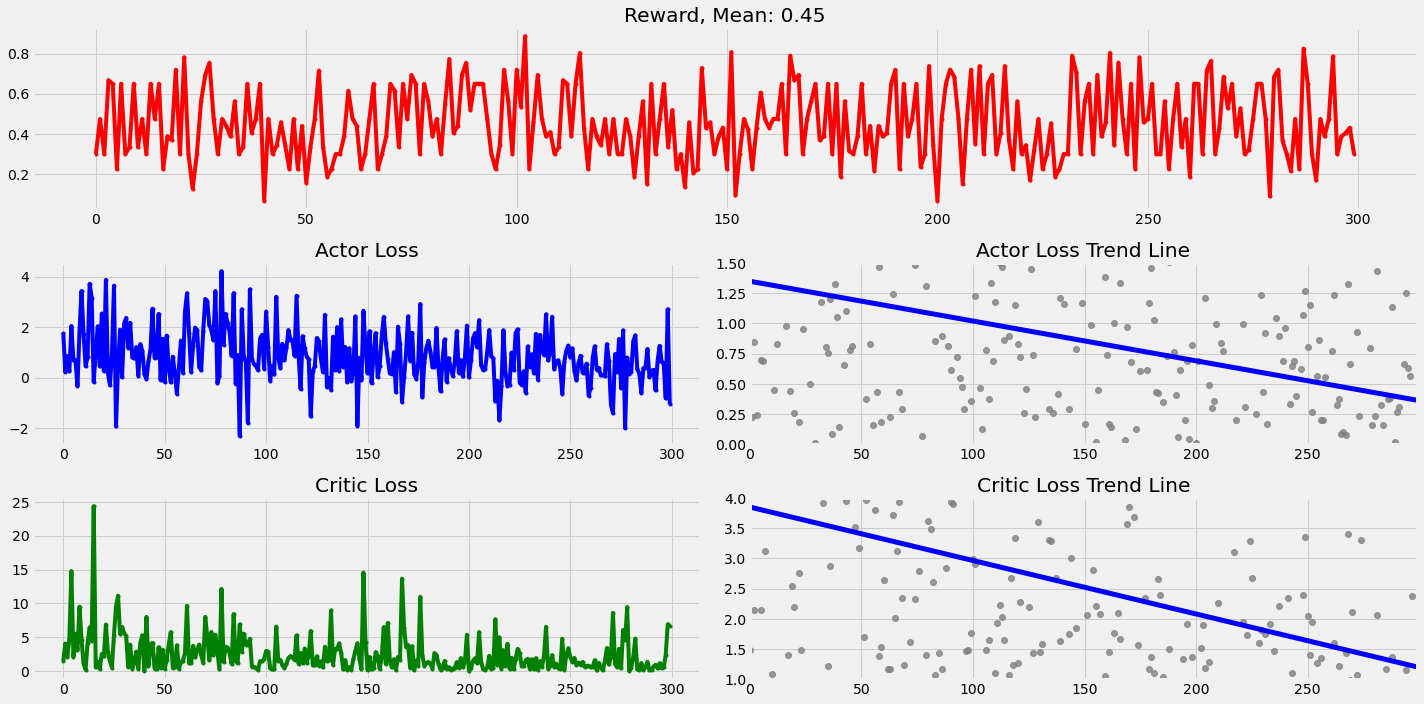

In [49]:
plt.figure(figsize=(20,10))

grid = (3,2)
plt.subplot2grid(grid, (0,0),rowspan=1,colspan=2)
plt.title('Reward, Mean: ' + str(round(sum(frac_l)/len(frac_l),2)))
plt.plot(frac_l[::10], 'r.-')

plt.subplot(323)
plt.title('Actor Loss')
plt.plot(avg_actor_loss_l[::10], 'b.-')

plt.subplot(324)
plt.title('Actor Loss Trend Line')
plt.ylim([0,1.5])
sns.regplot(x=[i for i in range(len(avg_actor_loss_l[::10]))],y=avg_actor_loss_l[::10], line_kws={'color':'blue','linewidth':'5'}, scatter_kws={'color':'grey'}, ci=None)

plt.subplot(325)
plt.title('Critic Loss')
plt.plot(avg_critic_loss_l[::10], 'g.-')

plt.subplot(326)
plt.title('Critic Loss Trend Line')
plt.ylim([1,4])
sns.regplot(x=[i for i in range(len(avg_critic_loss_l[::10]))],y=avg_critic_loss_l[::10], line_kws={'color':'blue','linewidth':'5'}, scatter_kws={'color':'grey'}, ci=None)

plt.tight_layout()

In [13]:
num_episode = 10000
env = Bpp3DEnv()
agent = ActorCriticAgent(s_size=20*20, a_size=200*20, lr=1e-8, gamma=0.99, action_size=1)
frac_list, avg_actor_loss_list, avg_critic_loss_list = [], [], []
N_MDD = 17

for episode in range(num_episode):
    st = time.time()
    env.reset()
    done = False
    step = 0
    
    history_list, upleft_list, used_boxes = [], [], []
    a_ops_list, next_history_list, reward_list = [], [], []
    action_list = []
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1,
                                     N_mdd=N_MDD,is_prediv='2h')
    boxes = boxes[0]
    
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1
        
        #hist
        for i, ul in enumerate(upleft_list):
            w_upleft += whole_upleft(*box_cornel([ul[0], ul[1]], used_boxes[i][0],
                                                used_boxes[i][1]), box[0], box[1])
        f_upleft = feasible_location(history, w_upleft,
                                    box[0],box[1],box[2],
                                    state_H = env.height,is2d=False)
        
        a_ops = action_options(f_upleft)
        action_ops, action = agent.get_action(history/20, a_ops)
        
        if action != -1:
            upleft = f_upleft[action]
            next_history = env.step(upleft, box[0], box[1], box[2])
            upleft_list.append(upleft)
            history_list.append(history)
            used_boxes.append(box)
            a_ops_list.append(action_ops)
            next_history_list.append(next_history)
            reward_list.append(env.terminal_reward())
            action_list.append(action)
            
            if step == len(boxes):
                done = True
        else:
            done = True
            
        if done:
            frac_list.append(env.terminal_reward())
            
            agent.train(history_list, action_list, a_ops_list, next_history_list, reward_list)
            avg_actor_loss_list.append(np.squeeze(agent.avg_actor_loss / float(step)))
            avg_critic_loss_list.append(np.squeeze(agent.avg_critic_loss / float(step)))
    log = "====episode: {:5d} | ".format(episode)
    log += "Terminal Reward: {:.3f} | ".format(env.terminal_reward())
    log += "Actor Loss: {:6f} | ".format(agent.avg_actor_loss.numpy()[0][0] / float(step))
    log += "Critic Loss: {:6f} | ".format(agent.avg_critic_loss.numpy()[0][0] / float(step))
    log += "time: {:.3f}".format(time.time() - st)
    print(log)
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

====episode:     0 | Terminal Reward: 0.150 | Actor Loss: 0.389084 | Critic Loss: 0.201534 | time: 0.073
====episode:     1 | Terminal Reward: 0.475 | Actor Loss: -0.303569 | Critic Loss: 1.017257 | time: 0.183
====episode:     2 | Terminal Reward: 0.405 | Actor Loss: -0.801644 | Critic Loss: 2.012366 | time: 0.130
====episode:     3 | Terminal Reward: 0.475 | Actor Loss: 0.448851 | Critic Loss: 0.372377 | time: 0.221
====episode:     4 | Terminal Reward: 0.536 | Actor Loss: 0.446403 | Critic Loss: 0.872356 | time: 0.177
====episode:     5 | Terminal Reward: 0.650 | Actor Loss: 0.825994 | Critic Loss: 2.100591 | time: 0.180
====episode:     6 | Terminal Reward: 0.210 | Actor Loss: 0.157013 | Critic Loss: 0.467403 | time: 0.097
====episode:     7 | Terminal Reward: 0.431 | Actor Loss: -0.500359 | Critic Loss: 1.505453 | time: 0.142
====episode:     8 | Terminal Reward: 0.458 | Actor Loss: -0.684463 | Critic Loss: 5.655752 | time: 0.133
====episode:     9 | Terminal Reward: 0.322 | Actor

====episode:    79 | Terminal Reward: 0.300 | Actor Loss: 0.170968 | Critic Loss: 2.934922 | time: 0.177
====episode:    80 | Terminal Reward: 0.475 | Actor Loss: 1.060867 | Critic Loss: 3.598663 | time: 0.189
====episode:    81 | Terminal Reward: 0.300 | Actor Loss: 0.482524 | Critic Loss: 1.922452 | time: 0.174
====episode:    82 | Terminal Reward: 0.405 | Actor Loss: -1.290938 | Critic Loss: 4.481637 | time: 0.095
====episode:    83 | Terminal Reward: 0.150 | Actor Loss: -0.161640 | Critic Loss: 0.103390 | time: 0.126
====episode:    84 | Terminal Reward: 0.300 | Actor Loss: 1.104911 | Critic Loss: 1.025503 | time: 0.066
====episode:    85 | Terminal Reward: 0.370 | Actor Loss: 0.633591 | Critic Loss: 0.376563 | time: 0.098
====episode:    86 | Terminal Reward: 0.685 | Actor Loss: 0.156185 | Critic Loss: 0.626020 | time: 0.219
====episode:    87 | Terminal Reward: 0.300 | Actor Loss: 0.014406 | Critic Loss: 0.460613 | time: 0.128
====episode:    88 | Terminal Reward: 0.729 | Actor L

====episode:   158 | Terminal Reward: 0.519 | Actor Loss: 2.889738 | Critic Loss: 15.454851 | time: 0.125
====episode:   159 | Terminal Reward: 0.388 | Actor Loss: 0.920769 | Critic Loss: 1.018509 | time: 0.192
====episode:   160 | Terminal Reward: 0.475 | Actor Loss: -0.932908 | Critic Loss: 0.947657 | time: 0.110
====episode:   161 | Terminal Reward: 0.650 | Actor Loss: 1.279593 | Critic Loss: 4.295493 | time: 0.225
====episode:   162 | Terminal Reward: 0.225 | Actor Loss: -0.369012 | Critic Loss: 0.671738 | time: 0.110
====episode:   163 | Terminal Reward: 0.562 | Actor Loss: -1.815625 | Critic Loss: 10.347501 | time: 0.225
====episode:   164 | Terminal Reward: 0.094 | Actor Loss: 0.700523 | Critic Loss: 0.342106 | time: 0.068
====episode:   165 | Terminal Reward: 0.225 | Actor Loss: 1.381806 | Critic Loss: 2.833044 | time: 0.132
====episode:   166 | Terminal Reward: 0.388 | Actor Loss: 1.077035 | Critic Loss: 0.688994 | time: 0.194
====episode:   167 | Terminal Reward: 0.217 | Acto

====episode:   236 | Terminal Reward: 0.650 | Actor Loss: -1.113752 | Critic Loss: 2.362572 | time: 0.215
====episode:   237 | Terminal Reward: 0.475 | Actor Loss: 0.463850 | Critic Loss: 2.355807 | time: 0.187
====episode:   238 | Terminal Reward: 0.225 | Actor Loss: -0.399089 | Critic Loss: 0.164836 | time: 0.073
====episode:   239 | Terminal Reward: 0.225 | Actor Loss: -0.049296 | Critic Loss: 1.447878 | time: 0.137
====episode:   240 | Terminal Reward: 0.300 | Actor Loss: -0.353005 | Critic Loss: 4.239797 | time: 0.156
====episode:   241 | Terminal Reward: 0.300 | Actor Loss: -0.251909 | Critic Loss: 0.054570 | time: 0.048
====episode:   242 | Terminal Reward: 0.799 | Actor Loss: 0.572123 | Critic Loss: 2.105006 | time: 0.194
====episode:   243 | Terminal Reward: 0.366 | Actor Loss: 0.176327 | Critic Loss: 0.431627 | time: 0.143
====episode:   244 | Terminal Reward: 0.300 | Actor Loss: 0.569202 | Critic Loss: 0.747386 | time: 0.063
====episode:   245 | Terminal Reward: 0.650 | Acto

====episode:   314 | Terminal Reward: 0.431 | Actor Loss: -0.032039 | Critic Loss: 0.220375 | time: 0.122
====episode:   315 | Terminal Reward: 0.225 | Actor Loss: -0.623888 | Critic Loss: 3.037621 | time: 0.143
====episode:   316 | Terminal Reward: 0.300 | Actor Loss: -0.099517 | Critic Loss: 0.385491 | time: 0.127
====episode:   317 | Terminal Reward: 0.300 | Actor Loss: 0.644054 | Critic Loss: 1.781532 | time: 0.156
====episode:   318 | Terminal Reward: 0.475 | Actor Loss: 0.191221 | Critic Loss: 0.440153 | time: 0.184
====episode:   319 | Terminal Reward: 0.103 | Actor Loss: 0.558700 | Critic Loss: 0.643154 | time: 0.080
====episode:   320 | Terminal Reward: 0.475 | Actor Loss: -1.333384 | Critic Loss: 5.061460 | time: 0.177
====episode:   321 | Terminal Reward: 0.225 | Actor Loss: 0.166608 | Critic Loss: 0.362201 | time: 0.126
====episode:   322 | Terminal Reward: 0.807 | Actor Loss: 0.875859 | Critic Loss: 1.980447 | time: 0.225
====episode:   323 | Terminal Reward: 0.405 | Actor

====episode:   392 | Terminal Reward: 0.458 | Actor Loss: 0.831347 | Critic Loss: 1.709074 | time: 0.246
====episode:   393 | Terminal Reward: 0.300 | Actor Loss: -0.257283 | Critic Loss: 0.170145 | time: 0.122
====episode:   394 | Terminal Reward: 0.458 | Actor Loss: 0.864335 | Critic Loss: 0.351752 | time: 0.210
====episode:   395 | Terminal Reward: 0.188 | Actor Loss: 0.974608 | Critic Loss: 1.766612 | time: 0.084
====episode:   396 | Terminal Reward: 0.475 | Actor Loss: -1.616576 | Critic Loss: 2.656046 | time: 0.251
====episode:   397 | Terminal Reward: 0.431 | Actor Loss: -0.388787 | Critic Loss: 3.680109 | time: 0.182
====episode:   398 | Terminal Reward: 0.562 | Actor Loss: 0.167661 | Critic Loss: 0.322246 | time: 0.206
====episode:   399 | Terminal Reward: 0.225 | Actor Loss: 0.455816 | Critic Loss: 0.475366 | time: 0.067
====episode:   400 | Terminal Reward: 0.300 | Actor Loss: 0.157042 | Critic Loss: 0.527884 | time: 0.144
====episode:   401 | Terminal Reward: 0.458 | Actor 

====episode:   470 | Terminal Reward: 0.405 | Actor Loss: -0.117686 | Critic Loss: 0.631563 | time: 0.239
====episode:   471 | Terminal Reward: 0.519 | Actor Loss: 2.259799 | Critic Loss: 3.796179 | time: 0.224
====episode:   472 | Terminal Reward: 0.300 | Actor Loss: -0.234718 | Critic Loss: 0.031033 | time: 0.157
====episode:   473 | Terminal Reward: 0.094 | Actor Loss: -0.486163 | Critic Loss: 0.912178 | time: 0.048
====episode:   474 | Terminal Reward: 0.694 | Actor Loss: 0.367415 | Critic Loss: 0.912782 | time: 0.290
====episode:   475 | Terminal Reward: 0.431 | Actor Loss: -0.996561 | Critic Loss: 2.096212 | time: 0.296
====episode:   476 | Terminal Reward: 0.300 | Actor Loss: 0.292840 | Critic Loss: 0.822964 | time: 0.108
====episode:   477 | Terminal Reward: 0.344 | Actor Loss: 0.228865 | Critic Loss: 0.263676 | time: 0.165
====episode:   478 | Terminal Reward: 0.195 | Actor Loss: 1.260054 | Critic Loss: 0.803392 | time: 0.197
====episode:   479 | Terminal Reward: 0.150 | Actor

====episode:   549 | Terminal Reward: 0.431 | Actor Loss: -0.661412 | Critic Loss: 0.933569 | time: 0.212
====episode:   550 | Terminal Reward: 0.300 | Actor Loss: -0.534024 | Critic Loss: 0.835368 | time: 0.105
====episode:   551 | Terminal Reward: 0.650 | Actor Loss: 1.180905 | Critic Loss: 5.649405 | time: 0.251
====episode:   552 | Terminal Reward: 0.300 | Actor Loss: 0.630014 | Critic Loss: 3.161812 | time: 0.234
====episode:   553 | Terminal Reward: 0.895 | Actor Loss: 1.467493 | Critic Loss: 2.063912 | time: 0.354
====episode:   554 | Terminal Reward: 0.475 | Actor Loss: -0.977168 | Critic Loss: 1.399305 | time: 0.277
====episode:   555 | Terminal Reward: 0.405 | Actor Loss: 1.937684 | Critic Loss: 4.899888 | time: 0.243
====episode:   556 | Terminal Reward: 0.206 | Actor Loss: -0.294210 | Critic Loss: 0.542665 | time: 0.137
====episode:   557 | Terminal Reward: 0.300 | Actor Loss: 1.427631 | Critic Loss: 1.019910 | time: 0.193
====episode:   558 | Terminal Reward: 0.475 | Actor

====episode:   628 | Terminal Reward: 0.405 | Actor Loss: -0.215586 | Critic Loss: 1.743457 | time: 0.215
====episode:   629 | Terminal Reward: 0.475 | Actor Loss: 0.263756 | Critic Loss: 1.225170 | time: 0.238
====episode:   630 | Terminal Reward: 0.370 | Actor Loss: 0.077474 | Critic Loss: 6.343181 | time: 0.259
====episode:   631 | Terminal Reward: 0.300 | Actor Loss: 0.939353 | Critic Loss: 4.584487 | time: 0.159
====episode:   632 | Terminal Reward: 0.344 | Actor Loss: 0.632581 | Critic Loss: 0.518546 | time: 0.173
====episode:   633 | Terminal Reward: 0.075 | Actor Loss: -0.024392 | Critic Loss: 0.201460 | time: 0.121
====episode:   634 | Terminal Reward: 0.300 | Actor Loss: 0.135887 | Critic Loss: 0.828866 | time: 0.253
====episode:   635 | Terminal Reward: 0.650 | Actor Loss: 1.077370 | Critic Loss: 1.480168 | time: 0.291
====episode:   636 | Terminal Reward: 0.225 | Actor Loss: 0.499384 | Critic Loss: 0.151484 | time: 0.173
====episode:   637 | Terminal Reward: 0.225 | Actor L

====episode:   707 | Terminal Reward: 0.562 | Actor Loss: 0.595161 | Critic Loss: 1.730021 | time: 0.276
====episode:   708 | Terminal Reward: 0.066 | Actor Loss: 0.006278 | Critic Loss: 0.111668 | time: 0.079
====episode:   709 | Terminal Reward: 0.519 | Actor Loss: 0.668656 | Critic Loss: 3.215405 | time: 0.203
====episode:   710 | Terminal Reward: 0.388 | Actor Loss: 0.774279 | Critic Loss: 0.880792 | time: 0.157
====episode:   711 | Terminal Reward: 0.843 | Actor Loss: 0.541079 | Critic Loss: 0.995868 | time: 0.245
====episode:   712 | Terminal Reward: 0.685 | Actor Loss: 0.090779 | Critic Loss: 0.110158 | time: 0.293
====episode:   713 | Terminal Reward: 0.803 | Actor Loss: 1.402200 | Critic Loss: 5.284591 | time: 0.351
====episode:   714 | Terminal Reward: 0.685 | Actor Loss: 0.975617 | Critic Loss: 2.536171 | time: 0.293
====episode:   715 | Terminal Reward: 0.188 | Actor Loss: 0.937891 | Critic Loss: 0.574041 | time: 0.208
====episode:   716 | Terminal Reward: 0.475 | Actor Los

====episode:   785 | Terminal Reward: 0.388 | Actor Loss: -0.660790 | Critic Loss: 0.817078 | time: 0.122
====episode:   786 | Terminal Reward: 0.772 | Actor Loss: -0.154458 | Critic Loss: 2.938793 | time: 0.181
====episode:   787 | Terminal Reward: 0.300 | Actor Loss: 0.688151 | Critic Loss: 0.794665 | time: 0.103
====episode:   788 | Terminal Reward: 0.934 | Actor Loss: 0.499711 | Critic Loss: 0.598221 | time: 0.224
====episode:   789 | Terminal Reward: 0.030 | Actor Loss: 0.263228 | Critic Loss: 0.111031 | time: 0.031
====episode:   790 | Terminal Reward: 0.672 | Actor Loss: 1.433546 | Critic Loss: 1.721213 | time: 0.177
====episode:   791 | Terminal Reward: 0.225 | Actor Loss: -0.439025 | Critic Loss: 0.566436 | time: 0.169
====episode:   792 | Terminal Reward: 0.388 | Actor Loss: 0.874747 | Critic Loss: 1.157895 | time: 0.091
====episode:   793 | Terminal Reward: 0.431 | Actor Loss: -0.487827 | Critic Loss: 1.113126 | time: 0.162
====episode:   794 | Terminal Reward: 0.150 | Actor

====episode:   864 | Terminal Reward: 0.300 | Actor Loss: -0.307018 | Critic Loss: 0.278414 | time: 0.168
====episode:   865 | Terminal Reward: 0.300 | Actor Loss: 0.497224 | Critic Loss: 0.332558 | time: 0.113
====episode:   866 | Terminal Reward: 0.098 | Actor Loss: 0.108424 | Critic Loss: 0.070376 | time: 0.048
====episode:   867 | Terminal Reward: 0.912 | Actor Loss: 2.071466 | Critic Loss: 5.733061 | time: 0.227
====episode:   868 | Terminal Reward: 0.150 | Actor Loss: -0.392126 | Critic Loss: 1.708825 | time: 0.089
====episode:   869 | Terminal Reward: 0.150 | Actor Loss: -0.053593 | Critic Loss: 0.802331 | time: 0.076
====episode:   870 | Terminal Reward: 0.405 | Actor Loss: 0.127978 | Critic Loss: 0.254813 | time: 0.150
====episode:   871 | Terminal Reward: 0.105 | Actor Loss: 0.288619 | Critic Loss: 0.240314 | time: 0.059
====episode:   872 | Terminal Reward: 0.300 | Actor Loss: 0.169560 | Critic Loss: 0.163666 | time: 0.104
====episode:   873 | Terminal Reward: 0.300 | Actor 

====episode:   942 | Terminal Reward: 0.300 | Actor Loss: 0.949957 | Critic Loss: 0.721888 | time: 0.120
====episode:   943 | Terminal Reward: 0.527 | Actor Loss: 0.358234 | Critic Loss: 6.625062 | time: 0.171
====episode:   944 | Terminal Reward: 0.060 | Actor Loss: 0.077321 | Critic Loss: 0.083758 | time: 0.064
====episode:   945 | Terminal Reward: 0.210 | Actor Loss: 0.383298 | Critic Loss: 0.606691 | time: 0.135
====episode:   946 | Terminal Reward: 0.388 | Actor Loss: 1.218097 | Critic Loss: 1.531789 | time: 0.157
====episode:   947 | Terminal Reward: 0.650 | Actor Loss: -0.791592 | Critic Loss: 6.412942 | time: 0.167
====episode:   948 | Terminal Reward: 0.300 | Actor Loss: 0.252036 | Critic Loss: 0.952958 | time: 0.147
====episode:   949 | Terminal Reward: 0.667 | Actor Loss: 0.796569 | Critic Loss: 1.759894 | time: 0.149
====episode:   950 | Terminal Reward: 0.650 | Actor Loss: 1.490270 | Critic Loss: 2.539114 | time: 0.222
====episode:   951 | Terminal Reward: 0.300 | Actor Lo

====episode:  1021 | Terminal Reward: 0.755 | Actor Loss: -0.408491 | Critic Loss: 6.968257 | time: 0.199
====episode:  1022 | Terminal Reward: 0.388 | Actor Loss: 1.415904 | Critic Loss: 2.317572 | time: 0.124
====episode:  1023 | Terminal Reward: 0.650 | Actor Loss: 1.890473 | Critic Loss: 2.906909 | time: 0.225
====episode:  1024 | Terminal Reward: 0.300 | Actor Loss: 0.801777 | Critic Loss: 0.491173 | time: 0.063
====episode:  1025 | Terminal Reward: 0.225 | Actor Loss: 0.768333 | Critic Loss: 0.283510 | time: 0.193
====episode:  1026 | Terminal Reward: 0.370 | Actor Loss: 0.612948 | Critic Loss: 0.525439 | time: 0.131
====episode:  1027 | Terminal Reward: 0.453 | Actor Loss: 1.063508 | Critic Loss: 1.057863 | time: 0.171
====episode:  1028 | Terminal Reward: 0.300 | Actor Loss: 0.252517 | Critic Loss: 1.621846 | time: 0.199
====episode:  1029 | Terminal Reward: 0.150 | Actor Loss: 0.141894 | Critic Loss: 0.021200 | time: 0.074
====episode:  1030 | Terminal Reward: 0.263 | Actor Lo

====episode:  1101 | Terminal Reward: 0.807 | Actor Loss: -0.369497 | Critic Loss: 0.893284 | time: 0.236
====episode:  1102 | Terminal Reward: 0.475 | Actor Loss: 1.001528 | Critic Loss: 1.957786 | time: 0.134
====episode:  1103 | Terminal Reward: 0.475 | Actor Loss: 0.106362 | Critic Loss: 1.382449 | time: 0.233
====episode:  1104 | Terminal Reward: 0.790 | Actor Loss: 2.211780 | Critic Loss: 5.211001 | time: 0.245
====episode:  1105 | Terminal Reward: 0.225 | Actor Loss: 0.473954 | Critic Loss: 0.120561 | time: 0.119
====episode:  1106 | Terminal Reward: 0.562 | Actor Loss: 1.494740 | Critic Loss: 2.193936 | time: 0.184
====episode:  1107 | Terminal Reward: 0.685 | Actor Loss: 0.055067 | Critic Loss: 0.146756 | time: 0.192
====episode:  1108 | Terminal Reward: 0.475 | Actor Loss: 0.014972 | Critic Loss: 0.160160 | time: 0.120
====episode:  1109 | Terminal Reward: 0.405 | Actor Loss: 2.002903 | Critic Loss: 2.173004 | time: 0.117
====episode:  1110 | Terminal Reward: 0.300 | Actor Lo

====episode:  1180 | Terminal Reward: 0.344 | Actor Loss: 0.145763 | Critic Loss: 0.440052 | time: 0.130
====episode:  1181 | Terminal Reward: 0.060 | Actor Loss: 0.085205 | Critic Loss: 0.078941 | time: 0.084
====episode:  1182 | Terminal Reward: 0.716 | Actor Loss: 1.501242 | Critic Loss: 3.897717 | time: 0.239
====episode:  1183 | Terminal Reward: 0.225 | Actor Loss: 0.553830 | Critic Loss: 0.385200 | time: 0.073
====episode:  1184 | Terminal Reward: 0.300 | Actor Loss: 0.337210 | Critic Loss: 1.858339 | time: 0.175
====episode:  1185 | Terminal Reward: 0.650 | Actor Loss: 1.194665 | Critic Loss: 3.141136 | time: 0.325
====episode:  1186 | Terminal Reward: 0.120 | Actor Loss: 0.219747 | Critic Loss: 0.264061 | time: 0.094
====episode:  1187 | Terminal Reward: 0.388 | Actor Loss: 0.016468 | Critic Loss: 0.180009 | time: 0.179
====episode:  1188 | Terminal Reward: 0.475 | Actor Loss: -0.878185 | Critic Loss: 17.225537 | time: 0.213
====episode:  1189 | Terminal Reward: 0.475 | Actor L

====episode:  1258 | Terminal Reward: 0.210 | Actor Loss: -0.167194 | Critic Loss: 0.219972 | time: 0.147
====episode:  1259 | Terminal Reward: 0.803 | Actor Loss: 0.216506 | Critic Loss: 1.793479 | time: 0.411
====episode:  1260 | Terminal Reward: 0.431 | Actor Loss: 1.288413 | Critic Loss: 1.863069 | time: 0.235
====episode:  1261 | Terminal Reward: 0.300 | Actor Loss: 0.823674 | Critic Loss: 0.403148 | time: 0.122
====episode:  1262 | Terminal Reward: 0.300 | Actor Loss: -0.294197 | Critic Loss: 2.602895 | time: 0.226
====episode:  1263 | Terminal Reward: 0.225 | Actor Loss: 1.217499 | Critic Loss: 1.289591 | time: 0.158
====episode:  1264 | Terminal Reward: 0.584 | Actor Loss: 0.609085 | Critic Loss: 1.537039 | time: 0.296
====episode:  1265 | Terminal Reward: 0.225 | Actor Loss: 2.105912 | Critic Loss: 2.183130 | time: 0.271
====episode:  1266 | Terminal Reward: 0.738 | Actor Loss: 0.529569 | Critic Loss: 0.642507 | time: 0.374
====episode:  1267 | Terminal Reward: 0.388 | Actor L

====episode:  1337 | Terminal Reward: 0.694 | Actor Loss: 1.643011 | Critic Loss: 7.448127 | time: 0.243
====episode:  1338 | Terminal Reward: 0.150 | Actor Loss: -0.017614 | Critic Loss: 0.686345 | time: 0.085
====episode:  1339 | Terminal Reward: 0.388 | Actor Loss: 1.647750 | Critic Loss: 4.935817 | time: 0.126
====episode:  1340 | Terminal Reward: 0.300 | Actor Loss: 0.802098 | Critic Loss: 0.383817 | time: 0.082
====episode:  1341 | Terminal Reward: 0.453 | Actor Loss: 0.046670 | Critic Loss: 1.124327 | time: 0.234
====episode:  1342 | Terminal Reward: 0.322 | Actor Loss: 0.777874 | Critic Loss: 0.704658 | time: 0.128
====episode:  1343 | Terminal Reward: 0.210 | Actor Loss: 1.308292 | Critic Loss: 1.725084 | time: 0.128
====episode:  1344 | Terminal Reward: 0.650 | Actor Loss: 1.296502 | Critic Loss: 1.282654 | time: 0.182
====episode:  1345 | Terminal Reward: 0.694 | Actor Loss: 0.616432 | Critic Loss: 1.177132 | time: 0.210
====episode:  1346 | Terminal Reward: 0.300 | Actor Lo

====episode:  1415 | Terminal Reward: 0.650 | Actor Loss: -0.512711 | Critic Loss: 1.512745 | time: 0.212
====episode:  1416 | Terminal Reward: 0.225 | Actor Loss: 0.816839 | Critic Loss: 1.602739 | time: 0.094
====episode:  1417 | Terminal Reward: 0.821 | Actor Loss: 2.060101 | Critic Loss: 4.039675 | time: 0.177
====episode:  1418 | Terminal Reward: 0.650 | Actor Loss: 0.057477 | Critic Loss: 0.128973 | time: 0.192
====episode:  1419 | Terminal Reward: 0.225 | Actor Loss: -0.351755 | Critic Loss: 2.349395 | time: 0.118
====episode:  1420 | Terminal Reward: 0.225 | Actor Loss: -0.412356 | Critic Loss: 8.506855 | time: 0.133
====episode:  1421 | Terminal Reward: 0.479 | Actor Loss: -0.179134 | Critic Loss: 3.271296 | time: 0.129
====episode:  1422 | Terminal Reward: 0.388 | Actor Loss: -0.544416 | Critic Loss: 0.747024 | time: 0.125
====episode:  1423 | Terminal Reward: 0.300 | Actor Loss: 1.294821 | Critic Loss: 2.354991 | time: 0.080
====episode:  1424 | Terminal Reward: 0.370 | Acto

====episode:  1493 | Terminal Reward: 0.388 | Actor Loss: 0.528051 | Critic Loss: 0.480987 | time: 0.197
====episode:  1494 | Terminal Reward: 0.790 | Actor Loss: -0.110602 | Critic Loss: 1.344479 | time: 0.249
====episode:  1495 | Terminal Reward: 0.650 | Actor Loss: 0.894183 | Critic Loss: 0.864759 | time: 0.253
====episode:  1496 | Terminal Reward: 0.300 | Actor Loss: 0.993402 | Critic Loss: 1.748699 | time: 0.235
====episode:  1497 | Terminal Reward: 0.475 | Actor Loss: 1.181504 | Critic Loss: 2.122821 | time: 0.198
====episode:  1498 | Terminal Reward: 0.150 | Actor Loss: 0.898595 | Critic Loss: 0.470092 | time: 0.114
====episode:  1499 | Terminal Reward: 0.225 | Actor Loss: -0.126108 | Critic Loss: 0.855988 | time: 0.114
====episode:  1500 | Terminal Reward: 0.300 | Actor Loss: -0.079859 | Critic Loss: 0.464192 | time: 0.221
====episode:  1501 | Terminal Reward: 0.188 | Actor Loss: 0.381825 | Critic Loss: 0.115390 | time: 0.142
====episode:  1502 | Terminal Reward: 0.225 | Actor 

====episode:  1571 | Terminal Reward: 0.090 | Actor Loss: 0.367188 | Critic Loss: 0.288043 | time: 0.046
====episode:  1572 | Terminal Reward: 0.335 | Actor Loss: 0.318530 | Critic Loss: 0.271152 | time: 0.146
====episode:  1573 | Terminal Reward: 0.300 | Actor Loss: 0.881328 | Critic Loss: 0.876652 | time: 0.131
====episode:  1574 | Terminal Reward: 0.206 | Actor Loss: 0.622365 | Critic Loss: 0.584498 | time: 0.103
====episode:  1575 | Terminal Reward: 0.150 | Actor Loss: 0.099062 | Critic Loss: 0.126608 | time: 0.106
====episode:  1576 | Terminal Reward: 0.458 | Actor Loss: 0.438087 | Critic Loss: 0.804690 | time: 0.104
====episode:  1577 | Terminal Reward: 0.475 | Actor Loss: -0.494751 | Critic Loss: 0.334081 | time: 0.150
====episode:  1578 | Terminal Reward: 0.650 | Actor Loss: 0.901196 | Critic Loss: 1.853746 | time: 0.165
====episode:  1579 | Terminal Reward: 0.300 | Actor Loss: -0.131322 | Critic Loss: 2.452056 | time: 0.151
====episode:  1580 | Terminal Reward: 0.716 | Actor L

====episode:  1649 | Terminal Reward: 0.803 | Actor Loss: 0.521274 | Critic Loss: 0.547775 | time: 0.211
====episode:  1650 | Terminal Reward: 0.388 | Actor Loss: -0.244722 | Critic Loss: 0.994132 | time: 0.120
====episode:  1651 | Terminal Reward: 0.300 | Actor Loss: 0.178055 | Critic Loss: 0.153479 | time: 0.156
====episode:  1652 | Terminal Reward: 0.225 | Actor Loss: 0.423556 | Critic Loss: 0.409211 | time: 0.103
====episode:  1653 | Terminal Reward: 0.422 | Actor Loss: 0.160180 | Critic Loss: 0.905303 | time: 0.111
====episode:  1654 | Terminal Reward: 0.650 | Actor Loss: -0.052511 | Critic Loss: 4.673301 | time: 0.176
====episode:  1655 | Terminal Reward: 0.440 | Actor Loss: -0.016764 | Critic Loss: 0.473372 | time: 0.186
====episode:  1656 | Terminal Reward: 0.440 | Actor Loss: -0.961323 | Critic Loss: 4.121990 | time: 0.135
====episode:  1657 | Terminal Reward: 0.300 | Actor Loss: 0.333160 | Critic Loss: 1.590041 | time: 0.191
====episode:  1658 | Terminal Reward: 0.781 | Actor

====episode:  1727 | Terminal Reward: 0.790 | Actor Loss: 0.267957 | Critic Loss: 2.430692 | time: 0.225
====episode:  1728 | Terminal Reward: 0.440 | Actor Loss: -0.116140 | Critic Loss: 1.946490 | time: 0.127
====episode:  1729 | Terminal Reward: 0.803 | Actor Loss: 0.574472 | Critic Loss: 0.590360 | time: 0.255
====episode:  1730 | Terminal Reward: 0.188 | Actor Loss: 0.143233 | Critic Loss: 0.362027 | time: 0.123
====episode:  1731 | Terminal Reward: 0.431 | Actor Loss: 2.067528 | Critic Loss: 7.054716 | time: 0.216
====episode:  1732 | Terminal Reward: 0.300 | Actor Loss: 1.394518 | Critic Loss: 2.869512 | time: 0.173
====episode:  1733 | Terminal Reward: 0.352 | Actor Loss: -0.175541 | Critic Loss: 0.150627 | time: 0.140
====episode:  1734 | Terminal Reward: 0.650 | Actor Loss: 0.279258 | Critic Loss: 0.636967 | time: 0.203
====episode:  1735 | Terminal Reward: 0.519 | Actor Loss: 0.001029 | Critic Loss: 0.368550 | time: 0.141
====episode:  1736 | Terminal Reward: 0.300 | Actor L

====episode:  1805 | Terminal Reward: 0.225 | Actor Loss: 0.387323 | Critic Loss: 0.275361 | time: 0.114
====episode:  1806 | Terminal Reward: 0.188 | Actor Loss: 0.753765 | Critic Loss: 1.165945 | time: 0.064
====episode:  1807 | Terminal Reward: 0.300 | Actor Loss: 0.787644 | Critic Loss: 0.821683 | time: 0.188
====episode:  1808 | Terminal Reward: 0.206 | Actor Loss: -0.266634 | Critic Loss: 1.125611 | time: 0.161
====episode:  1809 | Terminal Reward: 0.318 | Actor Loss: 0.798710 | Critic Loss: 0.653575 | time: 0.136
====episode:  1810 | Terminal Reward: 0.300 | Actor Loss: 0.086483 | Critic Loss: 0.115743 | time: 0.189
====episode:  1811 | Terminal Reward: 0.405 | Actor Loss: -0.301505 | Critic Loss: 0.340415 | time: 0.179
====episode:  1812 | Terminal Reward: 0.650 | Actor Loss: 0.569802 | Critic Loss: 0.669588 | time: 0.222
====episode:  1813 | Terminal Reward: 0.300 | Actor Loss: 0.683358 | Critic Loss: 0.328294 | time: 0.152
====episode:  1814 | Terminal Reward: 0.650 | Actor L

====episode:  1884 | Terminal Reward: 0.300 | Actor Loss: 0.370175 | Critic Loss: 0.194119 | time: 0.107
====episode:  1885 | Terminal Reward: 0.370 | Actor Loss: -0.689555 | Critic Loss: 1.927287 | time: 0.147
====episode:  1886 | Terminal Reward: 0.738 | Actor Loss: -0.006609 | Critic Loss: 0.742795 | time: 0.176
====episode:  1887 | Terminal Reward: 0.431 | Actor Loss: 0.432376 | Critic Loss: 2.953819 | time: 0.191
====episode:  1888 | Terminal Reward: 0.300 | Actor Loss: 0.951503 | Critic Loss: 4.029465 | time: 0.091
====episode:  1889 | Terminal Reward: 0.475 | Actor Loss: -0.340053 | Critic Loss: 0.765277 | time: 0.179
====episode:  1890 | Terminal Reward: 0.322 | Actor Loss: 0.669815 | Critic Loss: 1.007724 | time: 0.120
====episode:  1891 | Terminal Reward: 0.807 | Actor Loss: 1.308417 | Critic Loss: 6.003227 | time: 0.205
====episode:  1892 | Terminal Reward: 0.225 | Actor Loss: 1.162047 | Critic Loss: 0.799783 | time: 0.139
====episode:  1893 | Terminal Reward: 0.562 | Actor 

====episode:  1962 | Terminal Reward: 0.650 | Actor Loss: -0.376720 | Critic Loss: 0.664436 | time: 0.235
====episode:  1963 | Terminal Reward: 0.300 | Actor Loss: 0.189454 | Critic Loss: 0.599823 | time: 0.165
====episode:  1964 | Terminal Reward: 0.475 | Actor Loss: 1.207654 | Critic Loss: 1.888542 | time: 0.103
====episode:  1965 | Terminal Reward: 0.458 | Actor Loss: 0.302416 | Critic Loss: 5.303608 | time: 0.164
====episode:  1966 | Terminal Reward: 0.322 | Actor Loss: -0.314920 | Critic Loss: 0.463240 | time: 0.119
====episode:  1967 | Terminal Reward: 0.405 | Actor Loss: 0.570173 | Critic Loss: 0.912681 | time: 0.120
====episode:  1968 | Terminal Reward: 0.440 | Actor Loss: 0.221200 | Critic Loss: 0.328707 | time: 0.151
====episode:  1969 | Terminal Reward: 0.790 | Actor Loss: -0.086540 | Critic Loss: 0.850453 | time: 0.198
====episode:  1970 | Terminal Reward: 0.912 | Actor Loss: -0.481424 | Critic Loss: 0.264420 | time: 0.213
====episode:  1971 | Terminal Reward: 0.409 | Actor

====episode:  2040 | Terminal Reward: 0.388 | Actor Loss: 1.525925 | Critic Loss: 1.582235 | time: 0.136
====episode:  2041 | Terminal Reward: 0.300 | Actor Loss: -0.311371 | Critic Loss: 0.201208 | time: 0.089
====episode:  2042 | Terminal Reward: 0.300 | Actor Loss: 0.949896 | Critic Loss: 0.546668 | time: 0.155
====episode:  2043 | Terminal Reward: 0.300 | Actor Loss: 0.025771 | Critic Loss: 0.026161 | time: 0.061
====episode:  2044 | Terminal Reward: 0.405 | Actor Loss: -0.598618 | Critic Loss: 1.693960 | time: 0.156
====episode:  2045 | Terminal Reward: 0.366 | Actor Loss: 0.477902 | Critic Loss: 0.184247 | time: 0.180
====episode:  2046 | Terminal Reward: 0.431 | Actor Loss: -0.192384 | Critic Loss: 0.281423 | time: 0.206
====episode:  2047 | Terminal Reward: 0.388 | Actor Loss: 0.576912 | Critic Loss: 0.634352 | time: 0.157
====episode:  2048 | Terminal Reward: 0.188 | Actor Loss: 0.114497 | Critic Loss: 0.054194 | time: 0.061
====episode:  2049 | Terminal Reward: 0.225 | Actor 

====episode:  2118 | Terminal Reward: 0.388 | Actor Loss: 0.471144 | Critic Loss: 0.368153 | time: 0.221
====episode:  2119 | Terminal Reward: 0.475 | Actor Loss: 0.798697 | Critic Loss: 0.674069 | time: 0.113
====episode:  2120 | Terminal Reward: 0.825 | Actor Loss: -0.526527 | Critic Loss: 1.021555 | time: 0.277
====episode:  2121 | Terminal Reward: 0.335 | Actor Loss: 0.713384 | Critic Loss: 0.765436 | time: 0.089
====episode:  2122 | Terminal Reward: 0.431 | Actor Loss: 0.156775 | Critic Loss: 0.395139 | time: 0.169
====episode:  2123 | Terminal Reward: 0.475 | Actor Loss: 0.864235 | Critic Loss: 1.784454 | time: 0.088
====episode:  2124 | Terminal Reward: 0.921 | Actor Loss: 0.723441 | Critic Loss: 0.824602 | time: 0.252
====episode:  2125 | Terminal Reward: 0.431 | Actor Loss: 0.445119 | Critic Loss: 0.418752 | time: 0.104
====episode:  2126 | Terminal Reward: 0.300 | Actor Loss: -0.011513 | Critic Loss: 2.189018 | time: 0.139
====episode:  2127 | Terminal Reward: 0.475 | Actor L

====episode:  2196 | Terminal Reward: 0.188 | Actor Loss: -0.006591 | Critic Loss: 0.025239 | time: 0.120
====episode:  2197 | Terminal Reward: 0.210 | Actor Loss: -0.460342 | Critic Loss: 3.420611 | time: 0.127
====episode:  2198 | Terminal Reward: 0.344 | Actor Loss: 1.402195 | Critic Loss: 3.079146 | time: 0.177
====episode:  2199 | Terminal Reward: 0.300 | Actor Loss: 0.600358 | Critic Loss: 0.255604 | time: 0.093
====episode:  2200 | Terminal Reward: 0.225 | Actor Loss: 0.403488 | Critic Loss: 0.266092 | time: 0.060
====episode:  2201 | Terminal Reward: 0.300 | Actor Loss: 0.143767 | Critic Loss: 0.816818 | time: 0.170
====episode:  2202 | Terminal Reward: 0.475 | Actor Loss: -0.257801 | Critic Loss: 0.252199 | time: 0.122
====episode:  2203 | Terminal Reward: 0.300 | Actor Loss: -0.134540 | Critic Loss: 0.038010 | time: 0.048
====episode:  2204 | Terminal Reward: 0.165 | Actor Loss: 0.410559 | Critic Loss: 3.161589 | time: 0.134
====episode:  2205 | Terminal Reward: 0.475 | Actor

====episode:  2274 | Terminal Reward: 0.650 | Actor Loss: 1.099353 | Critic Loss: 2.536672 | time: 0.295
====episode:  2275 | Terminal Reward: 0.300 | Actor Loss: 0.459586 | Critic Loss: 0.247245 | time: 0.125
====episode:  2276 | Terminal Reward: 0.225 | Actor Loss: 0.194550 | Critic Loss: 0.062851 | time: 0.071
====episode:  2277 | Terminal Reward: 0.300 | Actor Loss: 1.416389 | Critic Loss: 0.797814 | time: 0.190
====episode:  2278 | Terminal Reward: 0.475 | Actor Loss: 0.377244 | Critic Loss: 0.228401 | time: 0.195
====episode:  2279 | Terminal Reward: 0.475 | Actor Loss: 0.459144 | Critic Loss: 0.436376 | time: 0.164
====episode:  2280 | Terminal Reward: 0.300 | Actor Loss: 0.151682 | Critic Loss: 0.284194 | time: 0.118
====episode:  2281 | Terminal Reward: 0.388 | Actor Loss: -0.464790 | Critic Loss: 2.047291 | time: 0.135
====episode:  2282 | Terminal Reward: 0.300 | Actor Loss: -0.290621 | Critic Loss: 0.206331 | time: 0.096
====episode:  2283 | Terminal Reward: 0.650 | Actor L

====episode:  2352 | Terminal Reward: 0.650 | Actor Loss: 0.885986 | Critic Loss: 1.739759 | time: 0.407
====episode:  2353 | Terminal Reward: 0.225 | Actor Loss: 0.131472 | Critic Loss: 0.438423 | time: 0.121
====episode:  2354 | Terminal Reward: 0.716 | Actor Loss: -0.332668 | Critic Loss: 1.575551 | time: 0.180
====episode:  2355 | Terminal Reward: 0.263 | Actor Loss: 0.424288 | Critic Loss: 0.806631 | time: 0.151
====episode:  2356 | Terminal Reward: 0.650 | Actor Loss: 0.126532 | Critic Loss: 0.370305 | time: 0.140
====episode:  2357 | Terminal Reward: 0.650 | Actor Loss: 0.297910 | Critic Loss: 0.278416 | time: 0.221
====episode:  2358 | Terminal Reward: 0.388 | Actor Loss: 0.728198 | Critic Loss: 0.853663 | time: 0.152
====episode:  2359 | Terminal Reward: 0.180 | Actor Loss: 0.348752 | Critic Loss: 0.082218 | time: 0.125
====episode:  2360 | Terminal Reward: 0.650 | Actor Loss: 0.403831 | Critic Loss: 0.409663 | time: 0.208
====episode:  2361 | Terminal Reward: 0.790 | Actor Lo

====episode:  2430 | Terminal Reward: 0.790 | Actor Loss: 0.221363 | Critic Loss: 0.512499 | time: 0.402
====episode:  2431 | Terminal Reward: 0.475 | Actor Loss: -0.021746 | Critic Loss: 0.405838 | time: 0.241
====episode:  2432 | Terminal Reward: 0.650 | Actor Loss: 0.341043 | Critic Loss: 0.229717 | time: 0.251
====episode:  2433 | Terminal Reward: 0.781 | Actor Loss: -0.483548 | Critic Loss: 1.131261 | time: 0.268
====episode:  2434 | Terminal Reward: 0.300 | Actor Loss: -0.127718 | Critic Loss: 0.176433 | time: 0.101
====episode:  2435 | Terminal Reward: 0.352 | Actor Loss: 1.808307 | Critic Loss: 2.044916 | time: 0.173
====episode:  2436 | Terminal Reward: 0.388 | Actor Loss: 0.184708 | Critic Loss: 0.221679 | time: 0.125
====episode:  2437 | Terminal Reward: 0.716 | Actor Loss: 1.358235 | Critic Loss: 3.771199 | time: 0.199
====episode:  2438 | Terminal Reward: 0.197 | Actor Loss: 0.399262 | Critic Loss: 0.088504 | time: 0.133
====episode:  2439 | Terminal Reward: 0.300 | Actor 

====episode:  2508 | Terminal Reward: 0.188 | Actor Loss: 0.012401 | Critic Loss: 0.369350 | time: 0.131
====episode:  2509 | Terminal Reward: 0.344 | Actor Loss: 0.582691 | Critic Loss: 0.424363 | time: 0.151
====episode:  2510 | Terminal Reward: 0.930 | Actor Loss: 0.382161 | Critic Loss: 0.810004 | time: 0.256
====episode:  2511 | Terminal Reward: 0.475 | Actor Loss: 0.789115 | Critic Loss: 0.684551 | time: 0.202
====episode:  2512 | Terminal Reward: 0.225 | Actor Loss: 0.050662 | Critic Loss: 0.277182 | time: 0.122
====episode:  2513 | Terminal Reward: 0.225 | Actor Loss: 0.577741 | Critic Loss: 0.245283 | time: 0.131
====episode:  2514 | Terminal Reward: 0.300 | Actor Loss: 0.885503 | Critic Loss: 3.516706 | time: 0.156
====episode:  2515 | Terminal Reward: 0.895 | Actor Loss: -0.223794 | Critic Loss: 0.838707 | time: 0.304
====episode:  2516 | Terminal Reward: 0.352 | Actor Loss: -0.168116 | Critic Loss: 1.087570 | time: 0.203
====episode:  2517 | Terminal Reward: 0.479 | Actor L

====episode:  2587 | Terminal Reward: 0.440 | Actor Loss: 0.582817 | Critic Loss: 1.441305 | time: 0.183
====episode:  2588 | Terminal Reward: 0.366 | Actor Loss: 0.840101 | Critic Loss: 0.667608 | time: 0.170
====episode:  2589 | Terminal Reward: 0.335 | Actor Loss: 0.971819 | Critic Loss: 4.956382 | time: 0.123
====episode:  2590 | Terminal Reward: 0.225 | Actor Loss: 1.598054 | Critic Loss: 1.661583 | time: 0.123
====episode:  2591 | Terminal Reward: 0.244 | Actor Loss: 0.150797 | Critic Loss: 0.146461 | time: 0.149
====episode:  2592 | Terminal Reward: 0.606 | Actor Loss: 1.099640 | Critic Loss: 0.785480 | time: 0.238
====episode:  2593 | Terminal Reward: 0.225 | Actor Loss: 0.420752 | Critic Loss: 0.208136 | time: 0.114
====episode:  2594 | Terminal Reward: 0.388 | Actor Loss: -0.371345 | Critic Loss: 12.991105 | time: 0.137
====episode:  2595 | Terminal Reward: 0.475 | Actor Loss: -0.101979 | Critic Loss: 1.069102 | time: 0.184
====episode:  2596 | Terminal Reward: 0.225 | Actor 

====episode:  2665 | Terminal Reward: 0.650 | Actor Loss: 1.171078 | Critic Loss: 2.988363 | time: 0.258
====episode:  2666 | Terminal Reward: 0.458 | Actor Loss: 0.033833 | Critic Loss: 0.407374 | time: 0.153
====episode:  2667 | Terminal Reward: 0.300 | Actor Loss: 0.474479 | Critic Loss: 0.243381 | time: 0.068
====episode:  2668 | Terminal Reward: 0.930 | Actor Loss: 1.063918 | Critic Loss: 1.029883 | time: 0.232
====episode:  2669 | Terminal Reward: 0.188 | Actor Loss: 0.074488 | Critic Loss: 0.362183 | time: 0.098
====episode:  2670 | Terminal Reward: 0.475 | Actor Loss: 0.952567 | Critic Loss: 1.520714 | time: 0.230
====episode:  2671 | Terminal Reward: 0.519 | Actor Loss: 0.688245 | Critic Loss: 0.462740 | time: 0.203
====episode:  2672 | Terminal Reward: 1.000 | Actor Loss: 0.607974 | Critic Loss: 0.901913 | time: 0.279
====episode:  2673 | Terminal Reward: 0.225 | Actor Loss: 1.401009 | Critic Loss: 1.015155 | time: 0.191
====episode:  2674 | Terminal Reward: 0.300 | Actor Los

====episode:  2743 | Terminal Reward: 0.650 | Actor Loss: -0.013379 | Critic Loss: 0.247845 | time: 0.274
====episode:  2744 | Terminal Reward: 0.458 | Actor Loss: 0.166628 | Critic Loss: 0.245920 | time: 0.159
====episode:  2745 | Terminal Reward: 0.056 | Actor Loss: 0.041754 | Critic Loss: 0.233506 | time: 0.040
====episode:  2746 | Terminal Reward: 0.300 | Actor Loss: 0.464819 | Critic Loss: 0.601945 | time: 0.156
====episode:  2747 | Terminal Reward: 0.300 | Actor Loss: 0.464471 | Critic Loss: 0.238984 | time: 0.134
====episode:  2748 | Terminal Reward: 0.738 | Actor Loss: 1.893516 | Critic Loss: 2.369245 | time: 0.424
====episode:  2749 | Terminal Reward: 0.344 | Actor Loss: 0.079530 | Critic Loss: 0.308856 | time: 0.169
====episode:  2750 | Terminal Reward: 0.150 | Actor Loss: 0.939929 | Critic Loss: 0.376683 | time: 0.151
====episode:  2751 | Terminal Reward: 0.150 | Actor Loss: 0.143890 | Critic Loss: 0.063328 | time: 0.054
====episode:  2752 | Terminal Reward: 0.431 | Actor Lo

====episode:  2821 | Terminal Reward: 0.711 | Actor Loss: 1.167398 | Critic Loss: 1.505485 | time: 0.150
====episode:  2822 | Terminal Reward: 0.650 | Actor Loss: -0.174272 | Critic Loss: 2.868674 | time: 0.229
====episode:  2823 | Terminal Reward: 0.225 | Actor Loss: 0.167432 | Critic Loss: 0.074475 | time: 0.116
====episode:  2824 | Terminal Reward: 1.000 | Actor Loss: -0.078881 | Critic Loss: 1.211544 | time: 0.274
====episode:  2825 | Terminal Reward: 0.300 | Actor Loss: 0.040232 | Critic Loss: 0.171654 | time: 0.159
====episode:  2826 | Terminal Reward: 0.150 | Actor Loss: 0.984048 | Critic Loss: 0.729768 | time: 0.116
====episode:  2827 | Terminal Reward: 0.300 | Actor Loss: 0.507521 | Critic Loss: 0.167153 | time: 0.186
====episode:  2828 | Terminal Reward: 0.300 | Actor Loss: -0.352552 | Critic Loss: 7.521776 | time: 0.202
====episode:  2829 | Terminal Reward: 0.475 | Actor Loss: 0.713349 | Critic Loss: 1.300924 | time: 0.152
====episode:  2830 | Terminal Reward: 0.650 | Actor 

====episode:  2899 | Terminal Reward: 0.738 | Actor Loss: -0.462729 | Critic Loss: 1.048072 | time: 0.259
====episode:  2900 | Terminal Reward: 0.475 | Actor Loss: 0.656944 | Critic Loss: 0.772255 | time: 0.231
====episode:  2901 | Terminal Reward: 0.694 | Actor Loss: -0.316192 | Critic Loss: 0.312334 | time: 0.221
====episode:  2902 | Terminal Reward: 0.781 | Actor Loss: 0.673543 | Critic Loss: 1.207240 | time: 0.242
====episode:  2903 | Terminal Reward: 0.344 | Actor Loss: -0.069713 | Critic Loss: 1.505564 | time: 0.183
====episode:  2904 | Terminal Reward: 0.475 | Actor Loss: -0.654645 | Critic Loss: 1.307418 | time: 0.183
====episode:  2905 | Terminal Reward: 0.409 | Actor Loss: -0.390170 | Critic Loss: 0.680966 | time: 0.170
====episode:  2906 | Terminal Reward: 0.366 | Actor Loss: 1.166449 | Critic Loss: 1.755994 | time: 0.135
====episode:  2907 | Terminal Reward: 0.300 | Actor Loss: 0.644186 | Critic Loss: 0.290853 | time: 0.100
====episode:  2908 | Terminal Reward: 0.475 | Acto

====episode:  2977 | Terminal Reward: 0.650 | Actor Loss: 0.325081 | Critic Loss: 0.650254 | time: 0.234
====episode:  2978 | Terminal Reward: 0.300 | Actor Loss: -1.252523 | Critic Loss: 4.653454 | time: 0.181
====episode:  2979 | Terminal Reward: 0.667 | Actor Loss: 0.209899 | Critic Loss: 0.183928 | time: 0.184
====episode:  2980 | Terminal Reward: 0.225 | Actor Loss: 0.409001 | Critic Loss: 0.200625 | time: 0.106
====episode:  2981 | Terminal Reward: 0.225 | Actor Loss: 1.272893 | Critic Loss: 1.770247 | time: 0.129
====episode:  2982 | Terminal Reward: 0.300 | Actor Loss: 0.428687 | Critic Loss: 0.216127 | time: 0.069
====episode:  2983 | Terminal Reward: 0.195 | Actor Loss: 0.859722 | Critic Loss: 3.140972 | time: 0.174
====episode:  2984 | Terminal Reward: 0.650 | Actor Loss: -0.315630 | Critic Loss: 2.625522 | time: 0.260
====episode:  2985 | Terminal Reward: 0.066 | Actor Loss: 0.278870 | Critic Loss: 0.053552 | time: 0.070
====episode:  2986 | Terminal Reward: 0.300 | Actor L

====episode:  3055 | Terminal Reward: 0.300 | Actor Loss: 0.737612 | Critic Loss: 0.800283 | time: 0.110
====episode:  3056 | Terminal Reward: 0.440 | Actor Loss: -0.063565 | Critic Loss: 0.617886 | time: 0.134
====episode:  3057 | Terminal Reward: 0.431 | Actor Loss: -0.457564 | Critic Loss: 3.286092 | time: 0.220
====episode:  3058 | Terminal Reward: 0.869 | Actor Loss: 0.012799 | Critic Loss: 0.169609 | time: 0.275
====episode:  3059 | Terminal Reward: 0.453 | Actor Loss: 0.459846 | Critic Loss: 0.675939 | time: 0.184
====episode:  3060 | Terminal Reward: 0.694 | Actor Loss: 0.766095 | Critic Loss: 2.184621 | time: 0.182
====episode:  3061 | Terminal Reward: 0.388 | Actor Loss: -0.159778 | Critic Loss: 0.027632 | time: 0.133
====episode:  3062 | Terminal Reward: 0.431 | Actor Loss: 0.696715 | Critic Loss: 0.419049 | time: 0.202
====episode:  3063 | Terminal Reward: 0.388 | Actor Loss: 0.358913 | Critic Loss: 0.236930 | time: 0.206
====episode:  3064 | Terminal Reward: 0.225 | Actor 

====episode:  3133 | Terminal Reward: 0.650 | Actor Loss: 0.512749 | Critic Loss: 0.433351 | time: 0.267
====episode:  3134 | Terminal Reward: 0.300 | Actor Loss: 0.740458 | Critic Loss: 0.639162 | time: 0.206
====episode:  3135 | Terminal Reward: 0.225 | Actor Loss: 0.388690 | Critic Loss: 0.192251 | time: 0.102
====episode:  3136 | Terminal Reward: 0.225 | Actor Loss: -0.003967 | Critic Loss: 0.187702 | time: 0.125
====episode:  3137 | Terminal Reward: 0.225 | Actor Loss: -0.201312 | Critic Loss: 0.072762 | time: 0.137
====episode:  3138 | Terminal Reward: 0.685 | Actor Loss: -0.499630 | Critic Loss: 2.072425 | time: 0.211
====episode:  3139 | Terminal Reward: 0.300 | Actor Loss: 0.596874 | Critic Loss: 0.392480 | time: 0.147
====episode:  3140 | Terminal Reward: 0.225 | Actor Loss: -0.390942 | Critic Loss: 1.963282 | time: 0.120
====episode:  3141 | Terminal Reward: 0.458 | Actor Loss: -0.720642 | Critic Loss: 3.865567 | time: 0.198
====episode:  3142 | Terminal Reward: 0.475 | Acto

====episode:  3212 | Terminal Reward: 0.300 | Actor Loss: 0.320929 | Critic Loss: 0.422600 | time: 0.182
====episode:  3213 | Terminal Reward: 0.335 | Actor Loss: 0.913152 | Critic Loss: 4.795117 | time: 0.132
====episode:  3214 | Terminal Reward: 0.650 | Actor Loss: 0.096466 | Critic Loss: 0.472871 | time: 0.280
====episode:  3215 | Terminal Reward: 0.300 | Actor Loss: -0.184239 | Critic Loss: 1.557697 | time: 0.170
====episode:  3216 | Terminal Reward: 0.075 | Actor Loss: 0.214127 | Critic Loss: 0.091812 | time: 0.060
====episode:  3217 | Terminal Reward: 0.440 | Actor Loss: 1.054614 | Critic Loss: 0.979410 | time: 0.188
====episode:  3218 | Terminal Reward: 0.128 | Actor Loss: -0.429986 | Critic Loss: 1.409940 | time: 0.107
====episode:  3219 | Terminal Reward: 0.300 | Actor Loss: 0.536931 | Critic Loss: 2.581648 | time: 0.232
====episode:  3220 | Terminal Reward: 0.370 | Actor Loss: -0.309123 | Critic Loss: 0.451891 | time: 0.125
====episode:  3221 | Terminal Reward: 0.615 | Actor 

====episode:  3291 | Terminal Reward: 0.318 | Actor Loss: 0.128825 | Critic Loss: 0.132490 | time: 0.121
====episode:  3292 | Terminal Reward: 0.300 | Actor Loss: 1.240769 | Critic Loss: 0.549682 | time: 0.210
====episode:  3293 | Terminal Reward: 0.225 | Actor Loss: -0.274425 | Critic Loss: 0.852960 | time: 0.103
====episode:  3294 | Terminal Reward: 0.131 | Actor Loss: 0.702057 | Critic Loss: 0.390290 | time: 0.070
====episode:  3295 | Terminal Reward: 0.869 | Actor Loss: 0.936092 | Critic Loss: 1.223060 | time: 0.244
====episode:  3296 | Terminal Reward: 0.300 | Actor Loss: -0.353368 | Critic Loss: 0.271728 | time: 0.122
====episode:  3297 | Terminal Reward: 0.405 | Actor Loss: 0.168388 | Critic Loss: 0.190553 | time: 0.164
====episode:  3298 | Terminal Reward: 0.131 | Actor Loss: 0.598536 | Critic Loss: 0.347587 | time: 0.089
====episode:  3299 | Terminal Reward: 0.388 | Actor Loss: 0.719321 | Critic Loss: 0.718997 | time: 0.174
====episode:  3300 | Terminal Reward: 0.475 | Actor L

====episode:  3369 | Terminal Reward: 0.650 | Actor Loss: 0.116901 | Critic Loss: 0.104563 | time: 0.263
====episode:  3370 | Terminal Reward: 0.109 | Actor Loss: 0.541429 | Critic Loss: 0.440593 | time: 0.063
====episode:  3371 | Terminal Reward: 0.300 | Actor Loss: 0.391343 | Critic Loss: 0.238687 | time: 0.205
====episode:  3372 | Terminal Reward: 0.807 | Actor Loss: 0.855573 | Critic Loss: 1.591196 | time: 0.279
====episode:  3373 | Terminal Reward: 0.300 | Actor Loss: 0.305955 | Critic Loss: 0.792097 | time: 0.184
====episode:  3374 | Terminal Reward: 0.729 | Actor Loss: 0.637316 | Critic Loss: 0.641921 | time: 0.171
====episode:  3375 | Terminal Reward: 0.956 | Actor Loss: 0.074444 | Critic Loss: 0.268726 | time: 0.261
====episode:  3376 | Terminal Reward: 0.475 | Actor Loss: 0.179660 | Critic Loss: 0.404647 | time: 0.240
====episode:  3377 | Terminal Reward: 0.738 | Actor Loss: -0.079339 | Critic Loss: 0.122680 | time: 0.172
====episode:  3378 | Terminal Reward: 0.344 | Actor Lo

====episode:  3447 | Terminal Reward: 0.475 | Actor Loss: 0.461658 | Critic Loss: 0.469383 | time: 0.174
====episode:  3448 | Terminal Reward: 0.352 | Actor Loss: -0.734628 | Critic Loss: 1.788360 | time: 0.138
====episode:  3449 | Terminal Reward: 0.300 | Actor Loss: 0.124150 | Critic Loss: 0.615691 | time: 0.197
====episode:  3450 | Terminal Reward: 0.300 | Actor Loss: 0.388278 | Critic Loss: 0.321648 | time: 0.120
====episode:  3451 | Terminal Reward: 0.738 | Actor Loss: 0.495010 | Critic Loss: 1.588755 | time: 0.266
====episode:  3452 | Terminal Reward: 0.453 | Actor Loss: 0.246057 | Critic Loss: 0.109713 | time: 0.073
====episode:  3453 | Terminal Reward: 0.650 | Actor Loss: 0.425069 | Critic Loss: 1.396306 | time: 0.205
====episode:  3454 | Terminal Reward: 0.440 | Actor Loss: -0.108636 | Critic Loss: 0.565327 | time: 0.161
====episode:  3455 | Terminal Reward: 0.225 | Actor Loss: 0.367305 | Critic Loss: 0.230970 | time: 0.122
====episode:  3456 | Terminal Reward: 0.694 | Actor L

====episode:  3525 | Terminal Reward: 0.453 | Actor Loss: 0.106587 | Critic Loss: 0.097856 | time: 0.176
====episode:  3526 | Terminal Reward: 0.440 | Actor Loss: 0.501549 | Critic Loss: 0.330513 | time: 0.198
====episode:  3527 | Terminal Reward: 0.300 | Actor Loss: 0.404604 | Critic Loss: 0.395763 | time: 0.115
====episode:  3528 | Terminal Reward: 0.225 | Actor Loss: 0.753471 | Critic Loss: 1.184459 | time: 0.135
====episode:  3529 | Terminal Reward: 0.344 | Actor Loss: 0.417419 | Critic Loss: 2.189762 | time: 0.116
====episode:  3530 | Terminal Reward: 0.206 | Actor Loss: 0.505754 | Critic Loss: 0.500027 | time: 0.109
====episode:  3531 | Terminal Reward: 0.300 | Actor Loss: 0.465369 | Critic Loss: 0.220326 | time: 0.198
====episode:  3532 | Terminal Reward: 0.453 | Actor Loss: 0.665076 | Critic Loss: 0.356932 | time: 0.197
====episode:  3533 | Terminal Reward: 0.225 | Actor Loss: 0.207370 | Critic Loss: 0.998888 | time: 0.199
====episode:  3534 | Terminal Reward: 0.431 | Actor Los

====episode:  3603 | Terminal Reward: 0.128 | Actor Loss: 0.280936 | Critic Loss: 0.456175 | time: 0.099
====episode:  3604 | Terminal Reward: 0.300 | Actor Loss: 0.837690 | Critic Loss: 1.448864 | time: 0.121
====episode:  3605 | Terminal Reward: 0.344 | Actor Loss: 0.458853 | Critic Loss: 2.295255 | time: 0.109
====episode:  3606 | Terminal Reward: 0.300 | Actor Loss: 0.055864 | Critic Loss: 1.264642 | time: 0.177
====episode:  3607 | Terminal Reward: 0.440 | Actor Loss: 0.369185 | Critic Loss: 0.478243 | time: 0.131
====episode:  3608 | Terminal Reward: 0.335 | Actor Loss: 0.511348 | Critic Loss: 0.400265 | time: 0.135
====episode:  3609 | Terminal Reward: 0.650 | Actor Loss: -0.695752 | Critic Loss: 2.871883 | time: 0.232
====episode:  3610 | Terminal Reward: 0.475 | Actor Loss: -1.267283 | Critic Loss: 2.368073 | time: 0.169
====episode:  3611 | Terminal Reward: 0.720 | Actor Loss: 0.181457 | Critic Loss: 0.672422 | time: 0.229
====episode:  3612 | Terminal Reward: 0.075 | Actor L

====episode:  3681 | Terminal Reward: 0.475 | Actor Loss: 0.675651 | Critic Loss: 0.455297 | time: 0.207
====episode:  3682 | Terminal Reward: 0.150 | Actor Loss: 0.146355 | Critic Loss: 0.234189 | time: 0.074
====episode:  3683 | Terminal Reward: 0.300 | Actor Loss: -0.435378 | Critic Loss: 0.389135 | time: 0.168
====episode:  3684 | Terminal Reward: 0.584 | Actor Loss: 0.267792 | Critic Loss: 0.618046 | time: 0.205
====episode:  3685 | Terminal Reward: 0.475 | Actor Loss: -1.789736 | Critic Loss: 6.134582 | time: 0.193
====episode:  3686 | Terminal Reward: 0.344 | Actor Loss: 1.855208 | Critic Loss: 2.790174 | time: 0.101
====episode:  3687 | Terminal Reward: 0.650 | Actor Loss: 0.092401 | Critic Loss: 0.634770 | time: 0.198
====episode:  3688 | Terminal Reward: 0.405 | Actor Loss: -0.177044 | Critic Loss: 2.867027 | time: 0.180
====episode:  3689 | Terminal Reward: 0.803 | Actor Loss: 0.657549 | Critic Loss: 0.545124 | time: 0.218
====episode:  3690 | Terminal Reward: 0.225 | Actor 

====episode:  3761 | Terminal Reward: 0.225 | Actor Loss: 0.375665 | Critic Loss: 0.188194 | time: 0.105
====episode:  3762 | Terminal Reward: 0.300 | Actor Loss: 0.900493 | Critic Loss: 0.324906 | time: 0.167
====episode:  3763 | Terminal Reward: 0.094 | Actor Loss: 0.564839 | Critic Loss: 0.232565 | time: 0.077
====episode:  3764 | Terminal Reward: 0.300 | Actor Loss: 1.306973 | Critic Loss: 2.794505 | time: 0.164
====episode:  3765 | Terminal Reward: 0.912 | Actor Loss: 0.518732 | Critic Loss: 0.966579 | time: 0.256
====episode:  3766 | Terminal Reward: 0.300 | Actor Loss: 0.341374 | Critic Loss: 0.192613 | time: 0.060
====episode:  3767 | Terminal Reward: 0.344 | Actor Loss: -0.155508 | Critic Loss: 0.275512 | time: 0.118
====episode:  3768 | Terminal Reward: 0.344 | Actor Loss: 0.303521 | Critic Loss: 0.308225 | time: 0.092
====episode:  3769 | Terminal Reward: 0.120 | Actor Loss: 1.244132 | Critic Loss: 1.981415 | time: 0.074
====episode:  3770 | Terminal Reward: 0.497 | Actor Lo

====episode:  3840 | Terminal Reward: 0.318 | Actor Loss: 0.173487 | Critic Loss: 0.516552 | time: 0.106
====episode:  3841 | Terminal Reward: 0.225 | Actor Loss: 0.300196 | Critic Loss: 0.158095 | time: 0.092
====episode:  3842 | Terminal Reward: 0.370 | Actor Loss: 0.056493 | Critic Loss: 0.377827 | time: 0.173
====episode:  3843 | Terminal Reward: 0.300 | Actor Loss: 0.131075 | Critic Loss: 0.239176 | time: 0.157
====episode:  3844 | Terminal Reward: 0.300 | Actor Loss: 0.045602 | Critic Loss: 1.213127 | time: 0.129
====episode:  3845 | Terminal Reward: 0.300 | Actor Loss: 0.230165 | Critic Loss: 0.245988 | time: 0.186
====episode:  3846 | Terminal Reward: 0.060 | Actor Loss: 0.159665 | Critic Loss: 0.052195 | time: 0.064
====episode:  3847 | Terminal Reward: 0.300 | Actor Loss: 0.997015 | Critic Loss: 0.769795 | time: 0.181
====episode:  3848 | Terminal Reward: 0.225 | Actor Loss: 0.091330 | Critic Loss: 0.034822 | time: 0.072
====episode:  3849 | Terminal Reward: 0.300 | Actor Los

====episode:  3918 | Terminal Reward: 0.388 | Actor Loss: -0.723173 | Critic Loss: 1.894410 | time: 0.168
====episode:  3919 | Terminal Reward: 0.150 | Actor Loss: 0.621731 | Critic Loss: 0.447892 | time: 0.109
====episode:  3920 | Terminal Reward: 0.527 | Actor Loss: -0.559949 | Critic Loss: 0.793810 | time: 0.190
====episode:  3921 | Terminal Reward: 0.225 | Actor Loss: -0.255393 | Critic Loss: 2.953714 | time: 0.151
====episode:  3922 | Terminal Reward: 0.825 | Actor Loss: 0.698723 | Critic Loss: 1.701779 | time: 0.208
====episode:  3923 | Terminal Reward: 0.453 | Actor Loss: 0.362203 | Critic Loss: 0.266002 | time: 0.145
====episode:  3924 | Terminal Reward: 0.388 | Actor Loss: -0.176453 | Critic Loss: 8.481222 | time: 0.129
====episode:  3925 | Terminal Reward: 0.650 | Actor Loss: 1.441605 | Critic Loss: 3.573005 | time: 0.223
====episode:  3926 | Terminal Reward: 0.225 | Actor Loss: 0.365626 | Critic Loss: 0.182444 | time: 0.092
====episode:  3927 | Terminal Reward: 0.300 | Actor

====episode:  3996 | Terminal Reward: 0.615 | Actor Loss: 1.795172 | Critic Loss: 4.059677 | time: 0.188
====episode:  3997 | Terminal Reward: 0.943 | Actor Loss: -0.368054 | Critic Loss: 1.437313 | time: 0.255
====episode:  3998 | Terminal Reward: 0.475 | Actor Loss: 0.278235 | Critic Loss: 0.818254 | time: 0.145
====episode:  3999 | Terminal Reward: 0.720 | Actor Loss: 1.214893 | Critic Loss: 1.247757 | time: 0.247
====episode:  4000 | Terminal Reward: 0.475 | Actor Loss: 0.738878 | Critic Loss: 0.491803 | time: 0.118
====episode:  4001 | Terminal Reward: 0.440 | Actor Loss: -1.199022 | Critic Loss: 1.843465 | time: 0.154
====episode:  4002 | Terminal Reward: 0.694 | Actor Loss: 0.614718 | Critic Loss: 0.354281 | time: 0.223
====episode:  4003 | Terminal Reward: 0.825 | Actor Loss: 0.070319 | Critic Loss: 0.158096 | time: 0.235
====episode:  4004 | Terminal Reward: 0.440 | Actor Loss: -0.001127 | Critic Loss: 0.196383 | time: 0.104
====episode:  4005 | Terminal Reward: 0.300 | Actor 

====episode:  4074 | Terminal Reward: 0.300 | Actor Loss: 0.336066 | Critic Loss: 1.011952 | time: 0.160
====episode:  4075 | Terminal Reward: 0.344 | Actor Loss: 1.616069 | Critic Loss: 1.061420 | time: 0.175
====episode:  4076 | Terminal Reward: 0.650 | Actor Loss: 0.465598 | Critic Loss: 0.489527 | time: 0.256
====episode:  4077 | Terminal Reward: 0.075 | Actor Loss: 0.109568 | Critic Loss: 0.047761 | time: 0.077
====episode:  4078 | Terminal Reward: 0.388 | Actor Loss: 0.504542 | Critic Loss: 0.955587 | time: 0.153
====episode:  4079 | Terminal Reward: 0.300 | Actor Loss: 1.685185 | Critic Loss: 1.766445 | time: 0.124
====episode:  4080 | Terminal Reward: 0.344 | Actor Loss: 0.497773 | Critic Loss: 0.629939 | time: 0.101
====episode:  4081 | Terminal Reward: 0.759 | Actor Loss: 0.763428 | Critic Loss: 0.463774 | time: 0.204
====episode:  4082 | Terminal Reward: 0.172 | Actor Loss: -0.088746 | Critic Loss: 0.093371 | time: 0.063
====episode:  4083 | Terminal Reward: 0.650 | Actor Lo

====episode:  4152 | Terminal Reward: 0.300 | Actor Loss: 0.069915 | Critic Loss: 0.099333 | time: 0.086
====episode:  4153 | Terminal Reward: 0.650 | Actor Loss: 0.928083 | Critic Loss: 3.106058 | time: 0.219
====episode:  4154 | Terminal Reward: 0.344 | Actor Loss: 0.577233 | Critic Loss: 0.652555 | time: 0.151
====episode:  4155 | Terminal Reward: 0.197 | Actor Loss: 0.189435 | Critic Loss: 0.038848 | time: 0.082
====episode:  4156 | Terminal Reward: 0.720 | Actor Loss: 0.322941 | Critic Loss: 0.280587 | time: 0.165
====episode:  4157 | Terminal Reward: 0.650 | Actor Loss: 0.473289 | Critic Loss: 0.340470 | time: 0.197
====episode:  4158 | Terminal Reward: 0.300 | Actor Loss: -0.052601 | Critic Loss: 0.281187 | time: 0.136
====episode:  4159 | Terminal Reward: 0.405 | Actor Loss: 0.080157 | Critic Loss: 0.399376 | time: 0.183
====episode:  4160 | Terminal Reward: 0.300 | Actor Loss: 0.158060 | Critic Loss: 0.432651 | time: 0.125
====episode:  4161 | Terminal Reward: 0.685 | Actor Lo

====episode:  4230 | Terminal Reward: 0.475 | Actor Loss: 1.018138 | Critic Loss: 1.251840 | time: 0.122
====episode:  4231 | Terminal Reward: 0.150 | Actor Loss: 0.088121 | Critic Loss: 0.067275 | time: 0.063
====episode:  4232 | Terminal Reward: 0.405 | Actor Loss: -0.074822 | Critic Loss: 0.125337 | time: 0.139
====episode:  4233 | Terminal Reward: 0.352 | Actor Loss: 0.415638 | Critic Loss: 1.234594 | time: 0.170
====episode:  4234 | Terminal Reward: 0.388 | Actor Loss: -0.184433 | Critic Loss: 0.738000 | time: 0.152
====episode:  4235 | Terminal Reward: 0.090 | Actor Loss: 0.424549 | Critic Loss: 0.308389 | time: 0.045
====episode:  4236 | Terminal Reward: 0.440 | Actor Loss: 0.205957 | Critic Loss: 0.266776 | time: 0.154
====episode:  4237 | Terminal Reward: 0.300 | Actor Loss: 0.043125 | Critic Loss: 0.110728 | time: 0.078
====episode:  4238 | Terminal Reward: 0.244 | Actor Loss: 0.007531 | Critic Loss: 0.250520 | time: 0.142
====episode:  4239 | Terminal Reward: 0.225 | Actor L

====episode:  4308 | Terminal Reward: 0.843 | Actor Loss: -0.104959 | Critic Loss: 1.752962 | time: 0.224
====episode:  4309 | Terminal Reward: 0.225 | Actor Loss: -0.216264 | Critic Loss: 1.694268 | time: 0.130
====episode:  4310 | Terminal Reward: 0.475 | Actor Loss: 0.823607 | Critic Loss: 1.121340 | time: 0.166
====episode:  4311 | Terminal Reward: 0.825 | Actor Loss: -0.417855 | Critic Loss: 0.409257 | time: 0.304
====episode:  4312 | Terminal Reward: 0.335 | Actor Loss: 1.372923 | Critic Loss: 1.455167 | time: 0.154
====episode:  4313 | Terminal Reward: 0.300 | Actor Loss: 1.968320 | Critic Loss: 8.938368 | time: 0.156
====episode:  4314 | Terminal Reward: 0.475 | Actor Loss: 0.516132 | Critic Loss: 0.537324 | time: 0.103
====episode:  4315 | Terminal Reward: 0.300 | Actor Loss: 0.418336 | Critic Loss: 0.347699 | time: 0.175
====episode:  4316 | Terminal Reward: 0.225 | Actor Loss: 0.280612 | Critic Loss: 0.254441 | time: 0.164
====episode:  4317 | Terminal Reward: 0.300 | Actor 

====episode:  4387 | Terminal Reward: 0.650 | Actor Loss: 0.922036 | Critic Loss: 0.713916 | time: 0.253
====episode:  4388 | Terminal Reward: 0.090 | Actor Loss: 0.425712 | Critic Loss: 0.308541 | time: 0.055
====episode:  4389 | Terminal Reward: 0.370 | Actor Loss: 0.459239 | Critic Loss: 2.328109 | time: 0.176
====episode:  4390 | Terminal Reward: 0.431 | Actor Loss: 0.658891 | Critic Loss: 0.728907 | time: 0.174
====episode:  4391 | Terminal Reward: 0.475 | Actor Loss: 1.343708 | Critic Loss: 2.399685 | time: 0.216
====episode:  4392 | Terminal Reward: 0.650 | Actor Loss: -0.083965 | Critic Loss: 0.378277 | time: 0.348
====episode:  4393 | Terminal Reward: 0.150 | Actor Loss: 0.380286 | Critic Loss: 0.196644 | time: 0.118
====episode:  4394 | Terminal Reward: 0.300 | Actor Loss: 0.994805 | Critic Loss: 0.662829 | time: 0.167
====episode:  4395 | Terminal Reward: 0.300 | Actor Loss: -0.115693 | Critic Loss: 0.009540 | time: 0.068
====episode:  4396 | Terminal Reward: 0.475 | Actor L

====episode:  4465 | Terminal Reward: 0.247 | Actor Loss: 0.508885 | Critic Loss: 0.116514 | time: 0.150
====episode:  4466 | Terminal Reward: 0.300 | Actor Loss: 0.361687 | Critic Loss: 0.174240 | time: 0.078
====episode:  4467 | Terminal Reward: 0.169 | Actor Loss: 0.442402 | Critic Loss: 0.078872 | time: 0.121
====episode:  4468 | Terminal Reward: 0.225 | Actor Loss: 0.229570 | Critic Loss: 0.212943 | time: 0.136
====episode:  4469 | Terminal Reward: 0.225 | Actor Loss: 0.236417 | Critic Loss: 0.146848 | time: 0.064
====episode:  4470 | Terminal Reward: 0.650 | Actor Loss: 0.263438 | Critic Loss: 0.401273 | time: 0.226
====episode:  4471 | Terminal Reward: 0.475 | Actor Loss: -0.233020 | Critic Loss: 0.130401 | time: 0.173
====episode:  4472 | Terminal Reward: 0.300 | Actor Loss: 0.778096 | Critic Loss: 0.685599 | time: 0.108
====episode:  4473 | Terminal Reward: 0.475 | Actor Loss: -0.634874 | Critic Loss: 1.368932 | time: 0.130
====episode:  4474 | Terminal Reward: 0.458 | Actor L

====episode:  4543 | Terminal Reward: 0.453 | Actor Loss: 2.209926 | Critic Loss: 13.962327 | time: 0.186
====episode:  4544 | Terminal Reward: 0.956 | Actor Loss: 0.107903 | Critic Loss: 0.790217 | time: 0.254
====episode:  4545 | Terminal Reward: 0.422 | Actor Loss: -0.509766 | Critic Loss: 2.134352 | time: 0.143
====episode:  4546 | Terminal Reward: 0.475 | Actor Loss: -0.665595 | Critic Loss: 1.295914 | time: 0.173
====episode:  4547 | Terminal Reward: 0.650 | Actor Loss: 0.831870 | Critic Loss: 2.138249 | time: 0.214
====episode:  4548 | Terminal Reward: 0.300 | Actor Loss: 0.904202 | Critic Loss: 1.148798 | time: 0.156
====episode:  4549 | Terminal Reward: 0.475 | Actor Loss: 0.365686 | Critic Loss: 0.188479 | time: 0.149
====episode:  4550 | Terminal Reward: 0.458 | Actor Loss: 0.253532 | Critic Loss: 0.183997 | time: 0.132
====episode:  4551 | Terminal Reward: 0.650 | Actor Loss: -0.228108 | Critic Loss: 0.430113 | time: 0.172
====episode:  4552 | Terminal Reward: 0.475 | Actor

====episode:  4621 | Terminal Reward: 0.225 | Actor Loss: -0.121961 | Critic Loss: 0.490732 | time: 0.153
====episode:  4622 | Terminal Reward: 0.869 | Actor Loss: 0.618128 | Critic Loss: 0.511678 | time: 0.245
====episode:  4623 | Terminal Reward: 0.685 | Actor Loss: 0.510100 | Critic Loss: 0.463370 | time: 0.180
====episode:  4624 | Terminal Reward: 0.650 | Actor Loss: -0.612437 | Critic Loss: 1.113645 | time: 0.216
====episode:  4625 | Terminal Reward: 0.300 | Actor Loss: 0.048263 | Critic Loss: 0.065103 | time: 0.092
====episode:  4626 | Terminal Reward: 0.300 | Actor Loss: 0.079709 | Critic Loss: 0.286976 | time: 0.168
====episode:  4627 | Terminal Reward: 0.790 | Actor Loss: -0.139290 | Critic Loss: 1.685675 | time: 0.269
====episode:  4628 | Terminal Reward: 0.300 | Actor Loss: -0.487883 | Critic Loss: 2.561622 | time: 0.122
====episode:  4629 | Terminal Reward: 0.300 | Actor Loss: 0.065104 | Critic Loss: 0.173758 | time: 0.127
====episode:  4630 | Terminal Reward: 0.225 | Actor

====episode:  4699 | Terminal Reward: 0.650 | Actor Loss: 0.548948 | Critic Loss: 0.544512 | time: 0.224
====episode:  4700 | Terminal Reward: 0.388 | Actor Loss: 0.057541 | Critic Loss: 0.188336 | time: 0.220
====episode:  4701 | Terminal Reward: 0.244 | Actor Loss: 1.214071 | Critic Loss: 0.776645 | time: 0.137
====episode:  4702 | Terminal Reward: 0.370 | Actor Loss: 0.328677 | Critic Loss: 0.265275 | time: 0.085
====episode:  4703 | Terminal Reward: 0.300 | Actor Loss: 0.126748 | Critic Loss: 0.176986 | time: 0.113
====episode:  4704 | Terminal Reward: 0.475 | Actor Loss: 1.339659 | Critic Loss: 3.578293 | time: 0.123
====episode:  4705 | Terminal Reward: 0.225 | Actor Loss: 0.110195 | Critic Loss: 0.178650 | time: 0.047
====episode:  4706 | Terminal Reward: 0.440 | Actor Loss: -0.737726 | Critic Loss: 1.761563 | time: 0.118
====episode:  4707 | Terminal Reward: 0.650 | Actor Loss: -0.441488 | Critic Loss: 1.733323 | time: 0.269
====episode:  4708 | Terminal Reward: 0.370 | Actor L

====episode:  4778 | Terminal Reward: 0.388 | Actor Loss: -0.385818 | Critic Loss: 0.384022 | time: 0.133
====episode:  4779 | Terminal Reward: 0.738 | Actor Loss: 1.626406 | Critic Loss: 7.976916 | time: 0.201
====episode:  4780 | Terminal Reward: 0.300 | Actor Loss: 0.106965 | Critic Loss: 0.485202 | time: 0.180
====episode:  4781 | Terminal Reward: 0.225 | Actor Loss: -0.004169 | Critic Loss: 0.207721 | time: 0.124
====episode:  4782 | Terminal Reward: 0.711 | Actor Loss: 0.800346 | Critic Loss: 0.612201 | time: 0.181
====episode:  4783 | Terminal Reward: 0.431 | Actor Loss: 0.455639 | Critic Loss: 0.376401 | time: 0.119
====episode:  4784 | Terminal Reward: 0.807 | Actor Loss: 0.731803 | Critic Loss: 0.678704 | time: 0.208
====episode:  4785 | Terminal Reward: 0.440 | Actor Loss: -0.154490 | Critic Loss: 3.736501 | time: 0.168
====episode:  4786 | Terminal Reward: 0.300 | Actor Loss: 0.080437 | Critic Loss: 0.091773 | time: 0.197
====episode:  4787 | Terminal Reward: 0.300 | Actor 

====episode:  4856 | Terminal Reward: 0.300 | Actor Loss: 1.317244 | Critic Loss: 1.556317 | time: 0.161
====episode:  4857 | Terminal Reward: 0.694 | Actor Loss: 0.987346 | Critic Loss: 0.883870 | time: 0.190
====episode:  4858 | Terminal Reward: 0.300 | Actor Loss: -0.445867 | Critic Loss: 2.206845 | time: 0.137
====episode:  4859 | Terminal Reward: 0.045 | Actor Loss: 0.214934 | Critic Loss: 0.073546 | time: 0.049
====episode:  4860 | Terminal Reward: 0.225 | Actor Loss: 0.137875 | Critic Loss: 0.122086 | time: 0.128
====episode:  4861 | Terminal Reward: 0.188 | Actor Loss: -0.359780 | Critic Loss: 1.332155 | time: 0.134
====episode:  4862 | Terminal Reward: 0.405 | Actor Loss: 0.905305 | Critic Loss: 1.688370 | time: 0.103
====episode:  4863 | Terminal Reward: 0.075 | Actor Loss: 0.434518 | Critic Loss: 0.325930 | time: 0.047
====episode:  4864 | Terminal Reward: 0.300 | Actor Loss: 0.218473 | Critic Loss: 0.194528 | time: 0.158
====episode:  4865 | Terminal Reward: 0.300 | Actor L

====episode:  4934 | Terminal Reward: 0.650 | Actor Loss: 1.007507 | Critic Loss: 4.463684 | time: 0.207
====episode:  4935 | Terminal Reward: 0.475 | Actor Loss: 2.179837 | Critic Loss: 8.746214 | time: 0.249
====episode:  4936 | Terminal Reward: 0.851 | Actor Loss: 0.302899 | Critic Loss: 0.287369 | time: 0.263
====episode:  4937 | Terminal Reward: 0.225 | Actor Loss: 0.469617 | Critic Loss: 0.257847 | time: 0.113
====episode:  4938 | Terminal Reward: 0.150 | Actor Loss: 0.081634 | Critic Loss: 0.046858 | time: 0.046
====episode:  4939 | Terminal Reward: 0.344 | Actor Loss: 1.166273 | Critic Loss: 1.548112 | time: 0.129
====episode:  4940 | Terminal Reward: 0.475 | Actor Loss: -0.042166 | Critic Loss: 0.868576 | time: 0.198
====episode:  4941 | Terminal Reward: 0.150 | Actor Loss: 0.445122 | Critic Loss: 0.231386 | time: 0.119
====episode:  4942 | Terminal Reward: 0.225 | Actor Loss: 0.918656 | Critic Loss: 1.197280 | time: 0.176
====episode:  4943 | Terminal Reward: 0.300 | Actor Lo

====episode:  5012 | Terminal Reward: 0.527 | Actor Loss: -0.008937 | Critic Loss: 0.312728 | time: 0.171
====episode:  5013 | Terminal Reward: 0.300 | Actor Loss: 0.643062 | Critic Loss: 0.298813 | time: 0.193
====episode:  5014 | Terminal Reward: 0.169 | Actor Loss: 0.332730 | Critic Loss: 0.520603 | time: 0.080
====episode:  5015 | Terminal Reward: 0.388 | Actor Loss: -0.393475 | Critic Loss: 1.840286 | time: 0.133
====episode:  5016 | Terminal Reward: 0.344 | Actor Loss: -0.307762 | Critic Loss: 0.476616 | time: 0.176
====episode:  5017 | Terminal Reward: 0.650 | Actor Loss: 0.237649 | Critic Loss: 0.260682 | time: 0.185
====episode:  5018 | Terminal Reward: 0.431 | Actor Loss: -0.393196 | Critic Loss: 0.497684 | time: 0.181
====episode:  5019 | Terminal Reward: 0.300 | Actor Loss: -0.273586 | Critic Loss: 1.537877 | time: 0.148
====episode:  5020 | Terminal Reward: 0.300 | Actor Loss: -0.071590 | Critic Loss: 0.012908 | time: 0.100
====episode:  5021 | Terminal Reward: 0.458 | Act

====episode:  5090 | Terminal Reward: 0.388 | Actor Loss: 1.064608 | Critic Loss: 1.345156 | time: 0.107
====episode:  5091 | Terminal Reward: 0.318 | Actor Loss: 0.461672 | Critic Loss: 0.247937 | time: 0.126
====episode:  5092 | Terminal Reward: 0.300 | Actor Loss: -0.039725 | Critic Loss: 0.002629 | time: 0.046
====episode:  5093 | Terminal Reward: 0.300 | Actor Loss: 0.484030 | Critic Loss: 0.762171 | time: 0.172
====episode:  5094 | Terminal Reward: 0.440 | Actor Loss: -0.104742 | Critic Loss: 2.916901 | time: 0.198
====episode:  5095 | Terminal Reward: 0.475 | Actor Loss: -0.136660 | Critic Loss: 0.120524 | time: 0.124
====episode:  5096 | Terminal Reward: 0.405 | Actor Loss: 0.093878 | Critic Loss: 1.574258 | time: 0.176
====episode:  5097 | Terminal Reward: 0.650 | Actor Loss: 1.033114 | Critic Loss: 0.708649 | time: 0.270
====episode:  5098 | Terminal Reward: 0.225 | Actor Loss: 0.864736 | Critic Loss: 1.672222 | time: 0.106
====episode:  5099 | Terminal Reward: 0.562 | Actor 

====episode:  5168 | Terminal Reward: 0.562 | Actor Loss: 0.328180 | Critic Loss: 0.312713 | time: 0.224
====episode:  5169 | Terminal Reward: 0.453 | Actor Loss: 0.783172 | Critic Loss: 1.404644 | time: 0.188
====episode:  5170 | Terminal Reward: 0.453 | Actor Loss: -0.215144 | Critic Loss: 1.605703 | time: 0.203
====episode:  5171 | Terminal Reward: 0.300 | Actor Loss: 0.206637 | Critic Loss: 0.709047 | time: 0.137
====episode:  5172 | Terminal Reward: 0.203 | Actor Loss: 0.170434 | Critic Loss: 0.131455 | time: 0.125
====episode:  5173 | Terminal Reward: 0.912 | Actor Loss: 0.881391 | Critic Loss: 1.760571 | time: 0.255
====episode:  5174 | Terminal Reward: 0.388 | Actor Loss: 0.467127 | Critic Loss: 0.494671 | time: 0.162
====episode:  5175 | Terminal Reward: 0.667 | Actor Loss: -0.140211 | Critic Loss: 0.961557 | time: 0.167
====episode:  5176 | Terminal Reward: 0.217 | Actor Loss: -0.090443 | Critic Loss: 0.138211 | time: 0.107
====episode:  5177 | Terminal Reward: 0.475 | Actor 

====episode:  5246 | Terminal Reward: 0.300 | Actor Loss: 0.458571 | Critic Loss: 0.447660 | time: 0.112
====episode:  5247 | Terminal Reward: 0.388 | Actor Loss: -0.076888 | Critic Loss: 0.054825 | time: 0.152
====episode:  5248 | Terminal Reward: 0.188 | Actor Loss: 0.286582 | Critic Loss: 0.246650 | time: 0.127
====episode:  5249 | Terminal Reward: 0.431 | Actor Loss: 0.545286 | Critic Loss: 0.799189 | time: 0.118
====episode:  5250 | Terminal Reward: 0.650 | Actor Loss: 0.594373 | Critic Loss: 0.983257 | time: 0.198
====episode:  5251 | Terminal Reward: 0.300 | Actor Loss: 0.580152 | Critic Loss: 0.730196 | time: 0.131
====episode:  5252 | Terminal Reward: 0.188 | Actor Loss: 0.331151 | Critic Loss: 0.079451 | time: 0.121
====episode:  5253 | Terminal Reward: 0.650 | Actor Loss: 0.082781 | Critic Loss: 0.857837 | time: 0.161
====episode:  5254 | Terminal Reward: 0.225 | Actor Loss: 0.565629 | Critic Loss: 0.571084 | time: 0.107
====episode:  5255 | Terminal Reward: 0.370 | Actor Lo

====episode:  5324 | Terminal Reward: 0.225 | Actor Loss: 0.221588 | Critic Loss: 0.173233 | time: 0.116
====episode:  5325 | Terminal Reward: 0.300 | Actor Loss: 0.082812 | Critic Loss: 0.752618 | time: 0.130
====episode:  5326 | Terminal Reward: 0.300 | Actor Loss: 1.139527 | Critic Loss: 0.799151 | time: 0.178
====episode:  5327 | Terminal Reward: 0.225 | Actor Loss: 1.367526 | Critic Loss: 1.323928 | time: 0.104
====episode:  5328 | Terminal Reward: 0.344 | Actor Loss: 0.337335 | Critic Loss: 0.121831 | time: 0.149
====episode:  5329 | Terminal Reward: 0.545 | Actor Loss: 0.488533 | Critic Loss: 0.297917 | time: 0.191
====episode:  5330 | Terminal Reward: 0.475 | Actor Loss: 0.590230 | Critic Loss: 1.063303 | time: 0.165
====episode:  5331 | Terminal Reward: 0.210 | Actor Loss: 0.787778 | Critic Loss: 1.797544 | time: 0.165
====episode:  5332 | Terminal Reward: 0.650 | Actor Loss: 0.426463 | Critic Loss: 1.205664 | time: 0.225
====episode:  5333 | Terminal Reward: 0.120 | Actor Los

====episode:  5403 | Terminal Reward: 0.344 | Actor Loss: 0.079595 | Critic Loss: 0.387538 | time: 0.168
====episode:  5404 | Terminal Reward: 0.135 | Actor Loss: -0.452415 | Critic Loss: 0.708200 | time: 0.075
====episode:  5405 | Terminal Reward: 0.431 | Actor Loss: 0.185751 | Critic Loss: 0.219721 | time: 0.121
====episode:  5406 | Terminal Reward: 0.172 | Actor Loss: 0.211731 | Critic Loss: 1.128265 | time: 0.155
====episode:  5407 | Terminal Reward: 0.225 | Actor Loss: 0.097370 | Critic Loss: 0.162432 | time: 0.047
====episode:  5408 | Terminal Reward: 0.475 | Actor Loss: -0.274714 | Critic Loss: 0.301571 | time: 0.188
====episode:  5409 | Terminal Reward: 0.169 | Actor Loss: 0.082844 | Critic Loss: 1.708231 | time: 0.149
====episode:  5410 | Terminal Reward: 0.388 | Actor Loss: 0.941747 | Critic Loss: 1.585956 | time: 0.148
====episode:  5411 | Terminal Reward: 0.458 | Actor Loss: 0.221807 | Critic Loss: 0.416154 | time: 0.105
====episode:  5412 | Terminal Reward: 0.519 | Actor L

====episode:  5482 | Terminal Reward: 0.650 | Actor Loss: 0.431555 | Critic Loss: 0.218614 | time: 0.215
====episode:  5483 | Terminal Reward: 0.790 | Actor Loss: 0.365272 | Critic Loss: 0.786345 | time: 0.232
====episode:  5484 | Terminal Reward: 0.650 | Actor Loss: 0.304779 | Critic Loss: 1.081849 | time: 0.269
====episode:  5485 | Terminal Reward: 0.300 | Actor Loss: 1.433023 | Critic Loss: 3.778841 | time: 0.140
====episode:  5486 | Terminal Reward: 0.475 | Actor Loss: 1.443070 | Critic Loss: 2.524822 | time: 0.208
====episode:  5487 | Terminal Reward: 0.300 | Actor Loss: 0.611942 | Critic Loss: 0.443278 | time: 0.123
====episode:  5488 | Terminal Reward: 0.131 | Actor Loss: 0.207529 | Critic Loss: 0.233260 | time: 0.050
====episode:  5489 | Terminal Reward: 0.475 | Actor Loss: -0.133956 | Critic Loss: 0.029226 | time: 0.184
====episode:  5490 | Terminal Reward: 0.300 | Actor Loss: 0.884905 | Critic Loss: 1.532677 | time: 0.094
====episode:  5491 | Terminal Reward: 0.318 | Actor Lo

====episode:  5560 | Terminal Reward: 0.300 | Actor Loss: 0.689898 | Critic Loss: 1.041169 | time: 0.173
====episode:  5561 | Terminal Reward: 0.422 | Actor Loss: -0.008726 | Critic Loss: 0.714189 | time: 0.172
====episode:  5562 | Terminal Reward: 0.475 | Actor Loss: 0.844737 | Critic Loss: 1.485694 | time: 0.177
====episode:  5563 | Terminal Reward: 0.335 | Actor Loss: -0.679117 | Critic Loss: 0.871171 | time: 0.092
====episode:  5564 | Terminal Reward: 0.300 | Actor Loss: 1.598737 | Critic Loss: 1.123239 | time: 0.165
====episode:  5565 | Terminal Reward: 0.370 | Actor Loss: -0.091701 | Critic Loss: 0.154731 | time: 0.118
====episode:  5566 | Terminal Reward: 0.475 | Actor Loss: -0.004399 | Critic Loss: 0.107972 | time: 0.134
====episode:  5567 | Terminal Reward: 0.344 | Actor Loss: 0.705212 | Critic Loss: 0.480899 | time: 0.150
====episode:  5568 | Terminal Reward: 0.131 | Actor Loss: 0.669414 | Critic Loss: 0.363174 | time: 0.060
====episode:  5569 | Terminal Reward: 0.318 | Actor

====episode:  5640 | Terminal Reward: 0.150 | Actor Loss: 0.215922 | Critic Loss: 0.055719 | time: 0.087
====episode:  5641 | Terminal Reward: 0.300 | Actor Loss: 0.031187 | Critic Loss: 0.090103 | time: 0.118
====episode:  5642 | Terminal Reward: 0.912 | Actor Loss: -0.112980 | Critic Loss: 0.180116 | time: 0.216
====episode:  5643 | Terminal Reward: 0.650 | Actor Loss: -0.096979 | Critic Loss: 0.417034 | time: 0.188
====episode:  5644 | Terminal Reward: 0.650 | Actor Loss: 0.583992 | Critic Loss: 0.662524 | time: 0.180
====episode:  5645 | Terminal Reward: 0.755 | Actor Loss: -0.413219 | Critic Loss: 0.429393 | time: 0.233
====episode:  5646 | Terminal Reward: 0.562 | Actor Loss: -0.002738 | Critic Loss: 0.105424 | time: 0.216
====episode:  5647 | Terminal Reward: 0.203 | Actor Loss: 0.251670 | Critic Loss: 0.084343 | time: 0.118
====episode:  5648 | Terminal Reward: 0.300 | Actor Loss: 0.039148 | Critic Loss: 0.175597 | time: 0.102
====episode:  5649 | Terminal Reward: 0.388 | Actor

====episode:  5719 | Terminal Reward: 0.300 | Actor Loss: 0.048440 | Critic Loss: 0.044147 | time: 0.145
====episode:  5720 | Terminal Reward: 0.475 | Actor Loss: 0.860853 | Critic Loss: 1.250832 | time: 0.151
====episode:  5721 | Terminal Reward: 0.562 | Actor Loss: -0.460471 | Critic Loss: 0.842968 | time: 0.217
====episode:  5722 | Terminal Reward: 0.300 | Actor Loss: 0.106141 | Critic Loss: 0.159309 | time: 0.136
====episode:  5723 | Terminal Reward: 0.188 | Actor Loss: 0.270962 | Critic Loss: 0.187363 | time: 0.120
====episode:  5724 | Terminal Reward: 0.650 | Actor Loss: -0.427363 | Critic Loss: 1.470182 | time: 0.237
====episode:  5725 | Terminal Reward: 0.431 | Actor Loss: 0.457242 | Critic Loss: 0.131944 | time: 0.200
====episode:  5726 | Terminal Reward: 0.300 | Actor Loss: 0.011412 | Critic Loss: 0.081286 | time: 0.149
====episode:  5727 | Terminal Reward: 0.388 | Actor Loss: -0.033763 | Critic Loss: 0.716330 | time: 0.119
====episode:  5728 | Terminal Reward: 0.128 | Actor 

====episode:  5797 | Terminal Reward: 0.948 | Actor Loss: 0.111737 | Critic Loss: 0.447712 | time: 0.217
====episode:  5798 | Terminal Reward: 0.225 | Actor Loss: -0.161536 | Critic Loss: 1.050204 | time: 0.119
====episode:  5799 | Terminal Reward: 0.300 | Actor Loss: 0.090582 | Critic Loss: 0.077373 | time: 0.120
====episode:  5800 | Terminal Reward: 0.300 | Actor Loss: 0.701180 | Critic Loss: 2.080605 | time: 0.114
====episode:  5801 | Terminal Reward: 0.562 | Actor Loss: -0.085203 | Critic Loss: 0.182012 | time: 0.116
====episode:  5802 | Terminal Reward: 0.120 | Actor Loss: 0.355365 | Critic Loss: 0.225759 | time: 0.057
====episode:  5803 | Terminal Reward: 0.388 | Actor Loss: 0.461456 | Critic Loss: 0.857599 | time: 0.098
====episode:  5804 | Terminal Reward: 0.300 | Actor Loss: -0.332683 | Critic Loss: 0.212359 | time: 0.102
====episode:  5805 | Terminal Reward: 0.300 | Actor Loss: 0.250900 | Critic Loss: 0.126148 | time: 0.172
====episode:  5806 | Terminal Reward: 0.527 | Actor 

====episode:  5876 | Terminal Reward: 0.650 | Actor Loss: 0.103760 | Critic Loss: 0.411723 | time: 0.185
====episode:  5877 | Terminal Reward: 0.142 | Actor Loss: -0.098990 | Critic Loss: 0.386583 | time: 0.099
====episode:  5878 | Terminal Reward: 0.475 | Actor Loss: -0.053122 | Critic Loss: 0.199977 | time: 0.115
====episode:  5879 | Terminal Reward: 0.405 | Actor Loss: 0.456601 | Critic Loss: 0.868059 | time: 0.136
====episode:  5880 | Terminal Reward: 0.825 | Actor Loss: 0.325411 | Critic Loss: 0.322405 | time: 0.235
====episode:  5881 | Terminal Reward: 0.225 | Actor Loss: 0.514778 | Critic Loss: 0.510687 | time: 0.099
====episode:  5882 | Terminal Reward: 0.352 | Actor Loss: -0.028880 | Critic Loss: 0.138585 | time: 0.132
====episode:  5883 | Terminal Reward: 0.685 | Actor Loss: 0.291302 | Critic Loss: 0.568108 | time: 0.183
====episode:  5884 | Terminal Reward: 0.225 | Actor Loss: 0.543866 | Critic Loss: 0.190708 | time: 0.112
====episode:  5885 | Terminal Reward: 0.300 | Actor 

====episode:  5955 | Terminal Reward: 0.475 | Actor Loss: 0.859440 | Critic Loss: 0.607514 | time: 0.191
====episode:  5956 | Terminal Reward: 0.440 | Actor Loss: 1.402692 | Critic Loss: 2.486351 | time: 0.154
====episode:  5957 | Terminal Reward: 0.650 | Actor Loss: 1.093813 | Critic Loss: 1.474967 | time: 0.170
====episode:  5958 | Terminal Reward: 0.352 | Actor Loss: -0.305573 | Critic Loss: 2.610229 | time: 0.157
====episode:  5959 | Terminal Reward: 0.650 | Actor Loss: 0.317670 | Critic Loss: 1.607761 | time: 0.222
====episode:  5960 | Terminal Reward: 0.388 | Actor Loss: 0.715893 | Critic Loss: 1.247476 | time: 0.129
====episode:  5961 | Terminal Reward: 0.860 | Actor Loss: 0.071790 | Critic Loss: 0.653060 | time: 0.231
====episode:  5962 | Terminal Reward: 0.300 | Actor Loss: -0.051976 | Critic Loss: 0.020623 | time: 0.074
====episode:  5963 | Terminal Reward: 0.195 | Actor Loss: 0.040369 | Critic Loss: 0.307853 | time: 0.058
====episode:  5964 | Terminal Reward: 0.188 | Actor L

====episode:  6033 | Terminal Reward: 0.694 | Actor Loss: 0.171535 | Critic Loss: 0.642920 | time: 0.187
====episode:  6034 | Terminal Reward: 0.150 | Actor Loss: 0.099657 | Critic Loss: 0.030108 | time: 0.059
====episode:  6035 | Terminal Reward: 0.891 | Actor Loss: 1.608798 | Critic Loss: 3.345994 | time: 0.198
====episode:  6036 | Terminal Reward: 0.225 | Actor Loss: 0.771885 | Critic Loss: 0.566524 | time: 0.136
====episode:  6037 | Terminal Reward: 0.335 | Actor Loss: -0.428513 | Critic Loss: 0.593985 | time: 0.123
====episode:  6038 | Terminal Reward: 0.388 | Actor Loss: -0.250796 | Critic Loss: 1.239174 | time: 0.104
====episode:  6039 | Terminal Reward: 0.772 | Actor Loss: 0.151388 | Critic Loss: 0.213981 | time: 0.219
====episode:  6040 | Terminal Reward: 0.703 | Actor Loss: -0.058265 | Critic Loss: 0.214339 | time: 0.190
====episode:  6041 | Terminal Reward: 0.759 | Actor Loss: 0.564885 | Critic Loss: 1.882287 | time: 0.195
====episode:  6042 | Terminal Reward: 0.431 | Actor 

====episode:  6112 | Terminal Reward: 0.510 | Actor Loss: 1.114358 | Critic Loss: 1.056846 | time: 0.130
====episode:  6113 | Terminal Reward: 0.458 | Actor Loss: 0.218902 | Critic Loss: 0.380941 | time: 0.115
====episode:  6114 | Terminal Reward: 0.388 | Actor Loss: 1.275731 | Critic Loss: 0.824928 | time: 0.174
====episode:  6115 | Terminal Reward: 0.300 | Actor Loss: -0.117305 | Critic Loss: 0.471683 | time: 0.141
====episode:  6116 | Terminal Reward: 0.497 | Actor Loss: 0.621352 | Critic Loss: 0.550625 | time: 0.171
====episode:  6117 | Terminal Reward: 0.075 | Actor Loss: 0.117899 | Critic Loss: 0.362082 | time: 0.061
====episode:  6118 | Terminal Reward: 0.300 | Actor Loss: 0.180645 | Critic Loss: 0.482394 | time: 0.144
====episode:  6119 | Terminal Reward: 0.475 | Actor Loss: 0.174467 | Critic Loss: 0.657291 | time: 0.116
====episode:  6120 | Terminal Reward: 0.300 | Actor Loss: 0.148162 | Critic Loss: 1.563378 | time: 0.172
====episode:  6121 | Terminal Reward: 0.650 | Actor Lo

====episode:  6190 | Terminal Reward: 0.475 | Actor Loss: 0.413908 | Critic Loss: 1.047161 | time: 0.151
====episode:  6191 | Terminal Reward: 0.344 | Actor Loss: -0.004803 | Critic Loss: 0.161231 | time: 0.144
====episode:  6192 | Terminal Reward: 0.860 | Actor Loss: -0.548050 | Critic Loss: 1.328577 | time: 0.256
====episode:  6193 | Terminal Reward: 0.453 | Actor Loss: 0.980057 | Critic Loss: 1.750215 | time: 0.155
====episode:  6194 | Terminal Reward: 0.322 | Actor Loss: -0.439429 | Critic Loss: 1.108077 | time: 0.160
====episode:  6195 | Terminal Reward: 0.090 | Actor Loss: 0.433703 | Critic Loss: 0.307129 | time: 0.047
====episode:  6196 | Terminal Reward: 0.475 | Actor Loss: -0.026372 | Critic Loss: 0.110251 | time: 0.120
====episode:  6197 | Terminal Reward: 0.458 | Actor Loss: 1.115375 | Critic Loss: 1.697326 | time: 0.158
====episode:  6198 | Terminal Reward: 0.650 | Actor Loss: 0.058378 | Critic Loss: 0.364157 | time: 0.219
====episode:  6199 | Terminal Reward: 0.475 | Actor

====episode:  6269 | Terminal Reward: 0.300 | Actor Loss: 0.283434 | Critic Loss: 0.437765 | time: 0.092
====episode:  6270 | Terminal Reward: 0.484 | Actor Loss: 0.774416 | Critic Loss: 0.797174 | time: 0.168
====episode:  6271 | Terminal Reward: 0.650 | Actor Loss: 0.544842 | Critic Loss: 0.332896 | time: 0.234
====episode:  6272 | Terminal Reward: 0.545 | Actor Loss: 0.473302 | Critic Loss: 0.305797 | time: 0.188
====episode:  6273 | Terminal Reward: 0.300 | Actor Loss: 0.161096 | Critic Loss: 0.250174 | time: 0.105
====episode:  6274 | Terminal Reward: 0.300 | Actor Loss: 0.300131 | Critic Loss: 0.280050 | time: 0.105
====episode:  6275 | Terminal Reward: 0.388 | Actor Loss: -0.543713 | Critic Loss: 0.690148 | time: 0.118
====episode:  6276 | Terminal Reward: 0.300 | Actor Loss: 0.976116 | Critic Loss: 2.442916 | time: 0.128
====episode:  6277 | Terminal Reward: 0.912 | Actor Loss: 0.506371 | Critic Loss: 0.450510 | time: 0.251
====episode:  6278 | Terminal Reward: 0.300 | Actor Lo

====episode:  6347 | Terminal Reward: 0.431 | Actor Loss: -0.110094 | Critic Loss: 0.213966 | time: 0.176
====episode:  6348 | Terminal Reward: 0.300 | Actor Loss: 0.203433 | Critic Loss: 0.079028 | time: 0.161
====episode:  6349 | Terminal Reward: 0.930 | Actor Loss: -0.086579 | Critic Loss: 2.378194 | time: 0.229
====episode:  6350 | Terminal Reward: 0.300 | Actor Loss: 0.316328 | Critic Loss: 0.468606 | time: 0.114
====episode:  6351 | Terminal Reward: 0.352 | Actor Loss: -0.229852 | Critic Loss: 0.629405 | time: 0.207
====episode:  6352 | Terminal Reward: 0.300 | Actor Loss: 0.869850 | Critic Loss: 2.870293 | time: 0.108
====episode:  6353 | Terminal Reward: 0.431 | Actor Loss: -0.914145 | Critic Loss: 2.030056 | time: 0.154
====episode:  6354 | Terminal Reward: 0.225 | Actor Loss: 0.194362 | Critic Loss: 0.092079 | time: 0.107
====episode:  6355 | Terminal Reward: 0.300 | Actor Loss: -0.212047 | Critic Loss: 0.122080 | time: 0.103
====episode:  6356 | Terminal Reward: 0.541 | Acto

====episode:  6425 | Terminal Reward: 0.650 | Actor Loss: 1.124720 | Critic Loss: 2.205541 | time: 0.249
====episode:  6426 | Terminal Reward: 0.694 | Actor Loss: 0.766530 | Critic Loss: 0.920783 | time: 0.100
====episode:  6427 | Terminal Reward: 0.105 | Actor Loss: 0.051996 | Critic Loss: 0.361188 | time: 0.087
====episode:  6428 | Terminal Reward: 0.225 | Actor Loss: 0.158104 | Critic Loss: 0.225004 | time: 0.086
====episode:  6429 | Terminal Reward: 0.300 | Actor Loss: 1.339150 | Critic Loss: 0.940124 | time: 0.133
====episode:  6430 | Terminal Reward: 0.738 | Actor Loss: 0.488524 | Critic Loss: 0.520554 | time: 0.217
====episode:  6431 | Terminal Reward: 0.650 | Actor Loss: -0.057512 | Critic Loss: 1.100176 | time: 0.203
====episode:  6432 | Terminal Reward: 0.300 | Actor Loss: 0.650333 | Critic Loss: 2.283221 | time: 0.119
====episode:  6433 | Terminal Reward: 0.422 | Actor Loss: -0.281949 | Critic Loss: 0.516173 | time: 0.183
====episode:  6434 | Terminal Reward: 0.650 | Actor L

====episode:  6504 | Terminal Reward: 0.703 | Actor Loss: 0.800572 | Critic Loss: 1.022639 | time: 0.128
====episode:  6505 | Terminal Reward: 0.650 | Actor Loss: 1.653936 | Critic Loss: 3.263905 | time: 0.268
====episode:  6506 | Terminal Reward: 0.335 | Actor Loss: 0.068225 | Critic Loss: 0.251141 | time: 0.171
====episode:  6507 | Terminal Reward: 0.449 | Actor Loss: 0.163377 | Critic Loss: 0.235229 | time: 0.184
====episode:  6508 | Terminal Reward: 0.562 | Actor Loss: 0.119086 | Critic Loss: 0.322669 | time: 0.175
====episode:  6509 | Terminal Reward: 0.300 | Actor Loss: 0.746660 | Critic Loss: 1.022029 | time: 0.207
====episode:  6510 | Terminal Reward: 0.667 | Actor Loss: 0.298507 | Critic Loss: 0.145659 | time: 0.225
====episode:  6511 | Terminal Reward: 0.519 | Actor Loss: 0.806760 | Critic Loss: 3.336372 | time: 0.180
====episode:  6512 | Terminal Reward: 0.150 | Actor Loss: 0.189923 | Critic Loss: 0.079279 | time: 0.094
====episode:  6513 | Terminal Reward: 0.694 | Actor Los

====episode:  6582 | Terminal Reward: 0.300 | Actor Loss: -0.014916 | Critic Loss: 0.059083 | time: 0.168
====episode:  6583 | Terminal Reward: 0.431 | Actor Loss: 0.139968 | Critic Loss: 0.175719 | time: 0.127
====episode:  6584 | Terminal Reward: 0.475 | Actor Loss: -0.000571 | Critic Loss: 0.109761 | time: 0.120
====episode:  6585 | Terminal Reward: 0.300 | Actor Loss: -0.658571 | Critic Loss: 6.867760 | time: 0.100
====episode:  6586 | Terminal Reward: 0.475 | Actor Loss: -0.517239 | Critic Loss: 0.279893 | time: 0.203
====episode:  6587 | Terminal Reward: 0.300 | Actor Loss: 0.224957 | Critic Loss: 0.670542 | time: 0.161
====episode:  6588 | Terminal Reward: 0.300 | Actor Loss: 0.473911 | Critic Loss: 0.471423 | time: 0.133
====episode:  6589 | Terminal Reward: 0.388 | Actor Loss: 0.136570 | Critic Loss: 0.052905 | time: 0.073
====episode:  6590 | Terminal Reward: 0.650 | Actor Loss: 0.401326 | Critic Loss: 0.404899 | time: 0.243
====episode:  6591 | Terminal Reward: 0.225 | Actor

====episode:  6662 | Terminal Reward: 0.188 | Actor Loss: 0.025269 | Critic Loss: 0.043997 | time: 0.145
====episode:  6663 | Terminal Reward: 0.519 | Actor Loss: -0.167479 | Critic Loss: 1.551507 | time: 0.199
====episode:  6664 | Terminal Reward: 0.431 | Actor Loss: -0.044828 | Critic Loss: 0.046416 | time: 0.135
====episode:  6665 | Terminal Reward: 0.300 | Actor Loss: -0.096426 | Critic Loss: 0.124648 | time: 0.252
====episode:  6666 | Terminal Reward: 0.225 | Actor Loss: -0.062161 | Critic Loss: 1.248802 | time: 0.131
====episode:  6667 | Terminal Reward: 0.141 | Actor Loss: 0.112503 | Critic Loss: 0.338506 | time: 0.156
====episode:  6668 | Terminal Reward: 0.409 | Actor Loss: -0.139727 | Critic Loss: 0.101001 | time: 0.224
====episode:  6669 | Terminal Reward: 0.965 | Actor Loss: -0.240121 | Critic Loss: 0.530209 | time: 0.367
====episode:  6670 | Terminal Reward: 0.650 | Actor Loss: 0.390298 | Critic Loss: 0.268204 | time: 0.249
====episode:  6671 | Terminal Reward: 0.150 | Act

====episode:  6742 | Terminal Reward: 0.225 | Actor Loss: 0.119424 | Critic Loss: 0.104926 | time: 0.066
====episode:  6743 | Terminal Reward: 0.225 | Actor Loss: 0.442701 | Critic Loss: 0.129991 | time: 0.116
====episode:  6744 | Terminal Reward: 0.225 | Actor Loss: 0.249933 | Critic Loss: 0.471963 | time: 0.130
====episode:  6745 | Terminal Reward: 0.300 | Actor Loss: 0.189571 | Critic Loss: 0.257769 | time: 0.111
====episode:  6746 | Terminal Reward: 0.225 | Actor Loss: 0.236474 | Critic Loss: 0.141571 | time: 0.141
====episode:  6747 | Terminal Reward: 0.225 | Actor Loss: 0.333022 | Critic Loss: 0.159407 | time: 0.097
====episode:  6748 | Terminal Reward: 0.912 | Actor Loss: 0.417889 | Critic Loss: 0.329128 | time: 0.273
====episode:  6749 | Terminal Reward: 0.388 | Actor Loss: 0.478781 | Critic Loss: 0.228090 | time: 0.154
====episode:  6750 | Terminal Reward: 0.210 | Actor Loss: -0.062770 | Critic Loss: 0.581176 | time: 0.129
====episode:  6751 | Terminal Reward: 0.440 | Actor Lo

====episode:  6820 | Terminal Reward: 0.075 | Actor Loss: -0.003306 | Critic Loss: 0.239746 | time: 0.055
====episode:  6821 | Terminal Reward: 0.790 | Actor Loss: 0.525361 | Critic Loss: 0.408972 | time: 0.233
====episode:  6822 | Terminal Reward: 0.344 | Actor Loss: 0.266593 | Critic Loss: 0.115885 | time: 0.193
====episode:  6823 | Terminal Reward: 0.300 | Actor Loss: -0.016334 | Critic Loss: 0.624427 | time: 0.162
====episode:  6824 | Terminal Reward: 0.475 | Actor Loss: 0.565163 | Critic Loss: 0.367073 | time: 0.248
====episode:  6825 | Terminal Reward: 0.405 | Actor Loss: -0.389322 | Critic Loss: 1.026701 | time: 0.161
====episode:  6826 | Terminal Reward: 0.300 | Actor Loss: -0.080969 | Critic Loss: 0.321191 | time: 0.153
====episode:  6827 | Terminal Reward: 0.300 | Actor Loss: 0.112964 | Critic Loss: 0.038677 | time: 0.176
====episode:  6828 | Terminal Reward: 0.405 | Actor Loss: 0.472389 | Critic Loss: 0.263025 | time: 0.182
====episode:  6829 | Terminal Reward: 0.667 | Actor

====episode:  6898 | Terminal Reward: 0.650 | Actor Loss: 0.424272 | Critic Loss: 0.391801 | time: 0.236
====episode:  6899 | Terminal Reward: 0.370 | Actor Loss: 0.728921 | Critic Loss: 0.949069 | time: 0.194
====episode:  6900 | Terminal Reward: 0.388 | Actor Loss: 0.587627 | Critic Loss: 0.633001 | time: 0.157
====episode:  6901 | Terminal Reward: 0.300 | Actor Loss: -0.173102 | Critic Loss: 0.480546 | time: 0.119
====episode:  6902 | Terminal Reward: 0.650 | Actor Loss: 0.028155 | Critic Loss: 0.275086 | time: 0.230
====episode:  6903 | Terminal Reward: 0.405 | Actor Loss: -0.190358 | Critic Loss: 1.839744 | time: 0.200
====episode:  6904 | Terminal Reward: 0.300 | Actor Loss: -0.020840 | Critic Loss: 0.607315 | time: 0.206
====episode:  6905 | Terminal Reward: 0.720 | Actor Loss: 0.372011 | Critic Loss: 0.691478 | time: 0.229
====episode:  6906 | Terminal Reward: 0.150 | Actor Loss: 0.155151 | Critic Loss: 0.222393 | time: 0.083
====episode:  6907 | Terminal Reward: 0.431 | Actor 

KeyboardInterrupt: 

In [ ]:
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [ ]:
plt.figure(figsize=(20,10))

grid = (3,2)
plt.subplot2grid(grid, (0,0),rowspan=1,colspan=2)
plt.title('Reward, Mean: ' + str(round(sum(frac_l)/len(frac_l),2)))
plt.plot(frac_l[::10], 'r.-')

plt.subplot(323)
plt.title('Actor Loss')
plt.plot(avg_actor_loss_l[::10], 'b.-')

plt.subplot(324)
plt.title('Actor Loss Trend Line')
plt.ylim([0,1.5])
sns.regplot(x=[i for i in range(len(avg_actor_loss_l[::10]))],y=avg_actor_loss_l[::10], line_kws={'color':'blue','linewidth':'5'}, scatter_kws={'color':'grey'}, ci=None)

plt.subplot(325)
plt.title('Critic Loss')
plt.plot(avg_critic_loss_l[::10], 'g.-')

plt.subplot(326)
plt.title('Critic Loss Trend Line')
plt.ylim([1,4])
sns.regplot(x=[i for i in range(len(avg_critic_loss_l[::10]))],y=avg_critic_loss_l[::10], line_kws={'color':'blue','linewidth':'5'}, scatter_kws={'color':'grey'}, ci=None)

plt.tight_layout()